In [1]:

import pandas as pd
from matplotlib import pyplot as plt # required for decomposition
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
import seaborn as sns
import numpy as np
import pymannkendall as mk
from statsmodels.stats.diagnostic import het_white
# SSL to overcome problem with ssl whn applying pd.read_csv()
import matplotlib.pyplot as plt

import datetime
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

from statsmodels.tsa.seasonal import seasonal_decompose

from pylab import rcParams


rcParams['figure.figsize'] = 15, 12

plt.style.use('seaborn-v0_8')

# Stationarity Function and Methods
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.stattools import adfuller

# Evaluation and Error functions
# Evaluation
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error , mean_absolute_percentage_error
from math import sqrt
#figures
rcParams['figure.figsize'] = 15, 8
plt.style.use('seaborn-v0_8')
#warnings
import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)


# Date function and holidays
from datetime import date
import holidays
#skimpy fro descriptive analysis and using transformars
import skimpy as sk

In [2]:
# libraries for modelling and preprocessing
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.utils.plotting import plot_series
from sktime.forecasting.base import ForecastingHorizon
from sktime.transformations.series.outlier_detection import HampelFilter
from sktime.forecasting.model_evaluation import evaluate
from sklearn.neighbors import KNeighborsRegressor
from sktime.forecasting.compose import make_reduction
from sktime.forecasting.naive import NaiveForecaster
from sktime.performance_metrics.forecasting import mean_absolute_error

import xgboost as xgb

from xgboost import XGBRegressor 


from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.forecasting.compose import (TransformedTargetForecaster)
from sktime.forecasting.model_selection import (ForecastingRandomizedSearchCV, ExpandingWindowSplitter, ForecastingGridSearchCV,SlidingWindowSplitter)
from sktime.transformations.series.boxcox import LogTransformer
from sktime.transformations.series.detrend import Deseasonalizer, Detrender

In [3]:
# Stationarity test and heterosedasticity tests
import pymannkendall as mk
from statsmodels.stats.diagnostic import het_white
from statsmodels.tsa.stattools import kpss

# Box-cox for power transformation
from scipy.stats import boxcox 
from scipy.stats import yeojohnson # substitute of boxcox which accepts negative values as well
from sklearn.preprocessing import RobustScaler

In [4]:
# Autocorrelation plot
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [5]:
# Heterosedasticity
from collections import namedtuple
import statsmodels.api as sm

In [6]:
online_sales=  pd.read_csv('online_retail_sales.csv',parse_dates = ['InvoiceDate'])

steps for the first section of the analysis:
**step 1**:
 Introduction and Preprocessing: Descriptive Analysis
        ● Emphasis on temporal variables and seasonality.
        ● Analysis of autocorrelation and partial autocorrelation.
        ● Decomposition of the components of the time series.
It is important to support your ideas with visualizations.

- First importing the file 
- then make the date of the invoice as index
- Then see some info and description about the file to know what to change and how to change and know the status of each variable
- Clean the data and find errors and outliers on each column and do shallow analysis on variables then focus on time variable
- The new column called daily profit should be careated and added to the new dataframe
- Analyze the day and profit vs days monthly daily seasonality (holidays effect)
- distribution analysis and outlier handling or scaling
- Correlation and autocorrelation and result
- stationary or not
- decomposition of time series


In [7]:
online_sales.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2022-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2022-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom


In [8]:
online_sales.set_index('InvoiceDate',inplace=True)
online_sales.index = online_sales.index.date

In [9]:
online_sales.info()

<class 'pandas.core.frame.DataFrame'>
Index: 541909 entries, 2022-12-01 to 2023-12-09
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   UnitPrice    541909 non-null  float64
 5   CustomerID   406829 non-null  float64
 6   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(4)
memory usage: 33.1+ MB


We have null values for 
1. Description : can be replace by other products
2. Customer ID : we can replace by unknown


In [10]:
online_sales.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


We have minus values in quantitiy and unit price should be checked.We can see we have missing values in CustomerID which we should handle. Also Customer ID should be in string format not number format which I am going to handle after handindling the NAs whichi i am going to set to Unknowns to detect if there is any pattern.
We can see that mean of quantity is near to 9.5 with Unitprice near to 4.6 , and the median of quantity is 3 and unit price is 2.08 which are so much less than the mean , and 75% of datapoints have less than 10 in quantitites and 4.13 in price.
max is 80995 in quantity and 38970 in Unit price.
min is -80995 in quantity and -11062.06 in unit price.
what I am curious to know in thise section:
1. what are the mix and mins? 
2. we have minus values which should be investigated on.
3. Outliers vs date that effects the mean

In [11]:
online_sales.describe(include='object')

,InvoiceNo,StockCode,Description,Country
count,541909,541909,540455,541909
unique,25900,4070,4223,38
top,573585,85123A,WHITE HANGING HEART T-LIGHT HOLDER,United Kingdom
freq,1114,2313,2369,495478


From the above table we can see that description missing values, United Kingdom is the most frquent country (so I use United Kingdom holidays to investigate holiday effect) with a great amount of 495478 out of 541909 number of entries in countries. top invoice number is 573585 which has a frequency of 1114 (? I want to see what are 573858 entries for White hanging t-light holder which is reasonable to be purchased in bunches, but incoice No is per customer)
here I want to check:
1. what are the top frequency Invoice No and StockCode and countries.

In [12]:
online_sales

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country
2022-12-01,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850.0,United Kingdom
2022-12-01,536365,71053,WHITE METAL LANTERN,6,3.39,17850.0,United Kingdom
2022-12-01,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,17850.0,United Kingdom
2022-12-01,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,17850.0,United Kingdom
2022-12-01,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...
2023-12-09,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,0.85,12680.0,France
2023-12-09,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2.10,12680.0,France
2023-12-09,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,4.15,12680.0,France
2023-12-09,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,4.15,12680.0,France


In [13]:
# Quantitative columns investigation
# 1. Max and Mins
online_sales_max_quantity = online_sales['Quantity'].max()
online_sales_min_quantity = online_sales['Quantity'].min()
online_sales_max_unitprice = online_sales['UnitPrice'].max()
online_sales_min_unitprice = online_sales['UnitPrice'].min()
display(online_sales_max_quantity)
display(online_sales_min_quantity)
display(online_sales_max_unitprice)
display(online_sales_min_unitprice)

80995

-80995

38970.0

-11062.06

In [14]:
# We can see that the max and min of quantity in the online sales are canceling out. let's see the related rows:
display(online_sales[online_sales['Quantity'] == online_sales_max_quantity])
display(online_sales[online_sales['Quantity'] == online_sales_min_quantity])
# I would like to get rid of these columns because the order was canceled and the amount is outlier so it would be better to get rid of them
online_sales = online_sales[~(online_sales['Quantity'] == online_sales_max_quantity)]
online_sales = online_sales[~(online_sales['Quantity'] == online_sales_min_quantity)]

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country
2023-12-09,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2.08,16446.0,United Kingdom


,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country
2023-12-09,C581484,23843,"PAPER CRAFT , LITTLE BIRDIE",-80995,2.08,16446.0,United Kingdom


In [15]:
online_sales.shape
# we can see it removed 2 rows

(541907, 7)

In [16]:
# Let's see the max and min in unitprice
display(online_sales[online_sales['UnitPrice'] == online_sales_max_unitprice])
display(online_sales[online_sales['UnitPrice'] == online_sales_min_unitprice])
# we can see the quantity in the max unitprice is -1 which is negative and the invoice code starts 
# with C which means cancellation. As it seems an aggregated cancellation and in the description it says it is manual I am going to keep it.
# For the min unitprice as it is adjusting bad debth I don't want to remove any of them

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country
2023-06-10,C556445,M,Manual,-1,38970.0,15098.0,United Kingdom


,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country
2023-08-12,A563186,B,Adjust bad debt,1,-11062.06,NaN,United Kingdom
2023-08-12,A563187,B,Adjust bad debt,1,-11062.06,NaN,United Kingdom


In [17]:
# Let's check the describe again
online_sales.describe()
# not that much change however we can see the min is reduced to -74215 which will be handled in minus quantity section

,Quantity,UnitPrice,CustomerID
count,541907.000000,541907.000000,406827.000000
mean,9.552285,4.611123,15287.684876
std,152.800603,96.760031,1713.602591
min,-74215.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,74215.000000,38970.000000,18287.000000


Let's find the answer to our questions in the qualitative data:
1. what are the top frequency Invoice No and StockCode and countries.


In [18]:
# Top frequency Invoice No
top_invoice_freq= online_sales['InvoiceNo'].value_counts().head(1)
top_invoice_rows = online_sales[online_sales['InvoiceNo']==top_invoice_freq.index[0]]
display(top_invoice_rows)
display(top_invoice_rows.describe())
display(top_invoice_rows.describe(include='object'))
display(top_invoice_rows.index.unique())

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country
2023-10-31,573585,11001,ASSTD DESIGN RACING CAR PEN,2,3.29,NaN,United Kingdom
2023-10-31,573585,15036,ASSORTED COLOURS SILK FAN,15,1.63,NaN,United Kingdom
2023-10-31,573585,15039,SANDALWOOD FAN,15,1.63,NaN,United Kingdom
2023-10-31,573585,15056BL,EDWARDIAN PARASOL BLACK,1,12.46,NaN,United Kingdom
2023-10-31,573585,15056N,EDWARDIAN PARASOL NATURAL,1,12.46,NaN,United Kingdom
...,...,...,...,...,...,...,...
2023-10-31,573585,90209C,PINK ENAMEL+GLASS HAIR COMB,3,2.07,NaN,United Kingdom
2023-10-31,573585,90214S,"LETTER ""S"" BLING KEY RING",1,0.83,NaN,United Kingdom
2023-10-31,573585,DOT,DOTCOM POSTAGE,1,2019.05,NaN,United Kingdom
2023-10-31,573585,gift_0001_20,Dotcomgiftshop Gift Voucher £20.00,1,16.67,NaN,United Kingdom


,Quantity,UnitPrice,CustomerID
count,1114.000000,1114.000000,0.0
mean,4.666068,6.311813,NaN
std,10.774824,60.507967,NaN
min,1.000000,0.420000,NaN
25%,1.000000,1.630000,NaN
50%,2.000000,3.290000,NaN
75%,5.000000,5.790000,NaN
max,200.000000,2019.050000,NaN


,InvoiceNo,StockCode,Description,Country
count,1114,1114,1114,1114
unique,1,1110,1108,1
top,573585,22998,CHARLIE LOLA BLUE HOT WATER BOTTLE,United Kingdom
freq,1114,2,2,1114


Index([2023-10-31], dtype='object')

As cusomer IDs are unknown and all entered on 31st of October as holidays (we know it is holloween) and I guess for some reason the data was entered manually or offline regarding technical issue or protal traffic or sth else. let's check the holidays for UK as the only country is UK:


In [19]:
country='UK'
date_to_check=datetime.date(2023,10,31)
is_holiday =date_to_check in holidays.CountryHoliday(country,years=date_to_check.year)
if is_holiday:
    print('The day is holiday', date_to_check)
else:
 print('The day is not a holiday', date_to_check)
 # Although it is not recognized as official holiday it is holloween and is widely celebrated

The day is not a holiday 2023-10-31


No that we have a good idea of  the top frequency invoice, let's look into the top frequency stock code.

In [20]:
top_invoice_freq= online_sales['StockCode'].value_counts().head(1)
top_invoice_rows = online_sales[online_sales['StockCode']==top_invoice_freq.index[0]]
display(top_invoice_rows)
display(top_invoice_rows.describe())
display(top_invoice_rows.describe(include='object'))
display(top_invoice_rows.index.unique())
display(top_invoice_rows['Description'].unique())
display(top_invoice_rows['Country'].unique())

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country
2022-12-01,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850.0,United Kingdom
2022-12-01,536373,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850.0,United Kingdom
2022-12-01,536375,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850.0,United Kingdom
2022-12-01,536390,85123A,WHITE HANGING HEART T-LIGHT HOLDER,64,2.55,17511.0,United Kingdom
2022-12-01,536394,85123A,WHITE HANGING HEART T-LIGHT HOLDER,32,2.55,13408.0,United Kingdom
...,...,...,...,...,...,...,...
2023-12-08,581439,85123A,CREAM HANGING HEART T-LIGHT HOLDER,1,5.79,NaN,United Kingdom
2023-12-08,581452,85123A,WHITE HANGING HEART T-LIGHT HOLDER,32,2.55,17675.0,United Kingdom
2023-12-08,581472,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.95,15796.0,United Kingdom
2023-12-09,581492,85123A,CREAM HANGING HEART T-LIGHT HOLDER,3,5.79,NaN,United Kingdom


,Quantity,UnitPrice,CustomerID
count,2313.000000,2313.000000,2077.000000
mean,16.787722,3.103238,15560.299470
std,117.301866,0.817211,1615.627887
min,-1930.000000,0.000000,12370.000000
25%,3.000000,2.950000,14239.000000
50%,6.000000,2.950000,15598.000000
75%,12.000000,2.950000,16931.000000
max,4000.000000,5.910000,18283.000000


,InvoiceNo,StockCode,Description,Country
count,2313,2313,2313,2313
unique,2246,1,4,16
top,560271,85123A,WHITE HANGING HEART T-LIGHT HOLDER,United Kingdom
freq,3,2313,2302,2215


Index([2022-12-01, 2022-12-02, 2022-12-03, 2022-12-05, 2022-12-06, 2022-12-07,
       2022-12-08, 2022-12-09, 2022-12-10, 2022-12-12,
       ...
       2023-11-29, 2023-11-30, 2023-12-01, 2023-12-02, 2023-12-04, 2023-12-05,
       2023-12-06, 2023-12-07, 2023-12-08, 2023-12-09],
      dtype='object', length=305)

array(['WHITE HANGING HEART T-LIGHT HOLDER', '?',
       'wrongly marked carton 22804',
       'CREAM HANGING HEART T-LIGHT HOLDER'], dtype=object)

array(['United Kingdom', 'Spain', 'Cyprus', 'EIRE', 'Portugal',
       'Netherlands', 'Australia', 'Singapore', 'Switzerland', 'Finland',
       'Channel Islands', 'France', 'Malta', 'Italy', 'Israel', 'Germany'],
      dtype=object)

It seems that this hanging heart holder T-light has the max quantity in 16 countries but it is because of its nature people used to get hangers in bulks. However we can see that we have description with ? and also a country named EIRE which is the irish name for Irland. So for now let's investigate on descriptions with ? all over the data frame

In [21]:
# Description with ?
display (online_sales[online_sales['Description']== '?'].count())
display( online_sales[online_sales['Description']== '?'])

InvoiceNo      47
StockCode      47
Description    47
Quantity       47
UnitPrice      47
CustomerID      0
Country        47
dtype: int64

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country
2022-12-03,537032,21275,?,-30,0.0,NaN,United Kingdom
2022-12-09,538090,20956,?,-723,0.0,NaN,United Kingdom
2022-12-20,539494,21479,?,752,0.0,NaN,United Kingdom
2023-01-04,540100,22837,?,-106,0.0,NaN,United Kingdom
2023-01-10,540558,21258,?,-29,0.0,NaN,United Kingdom
2023-01-10,540651,82599,?,-290,0.0,NaN,United Kingdom
2023-01-24,541882,48185,?,-57,0.0,NaN,United Kingdom
2023-02-01,542861,47591B,?,-207,0.0,NaN,United Kingdom
2023-02-18,544410,84997C,?,-741,0.0,NaN,United Kingdom
2023-02-22,544649,21621,?,-400,0.0,NaN,United Kingdom


We should get rid of these as they have unit price of 0 and customer ID as Nans.


In [22]:
display(online_sales.shape[0])
online_sales = online_sales[ online_sales['Description'] != '?']
display( online_sales[online_sales['Description']== '?'])
display(online_sales.shape[0])

541907

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country


541860

 we deleted the 47 rows with description equals to ?. Now let sort out how country is distributed

In [23]:
# Here I just analyze based on the describe and info. 
# I would analyze country vs profit and time in next section after cleaning the data
unique_countries_freq= online_sales['Country'].value_counts()
display(unique_countries_freq.shape[0])
display(unique_countries_freq.head(38))

38

Country
United Kingdom          495429
Germany                   9495
France                    8557
EIRE                      8196
Spain                     2533
Netherlands               2371
Belgium                   2069
Switzerland               2002
Portugal                  1519
Australia                 1259
Norway                    1086
Italy                      803
Channel Islands            758
Finland                    695
Cyprus                     622
Sweden                     462
Unspecified                446
Austria                    401
Denmark                    389
Japan                      358
Poland                     341
Israel                     297
USA                        291
Hong Kong                  288
Singapore                  229
Iceland                    182
Canada                     151
Greece                     146
Malta                      127
United Arab Emirates        68
European Community          61
RSA                         58


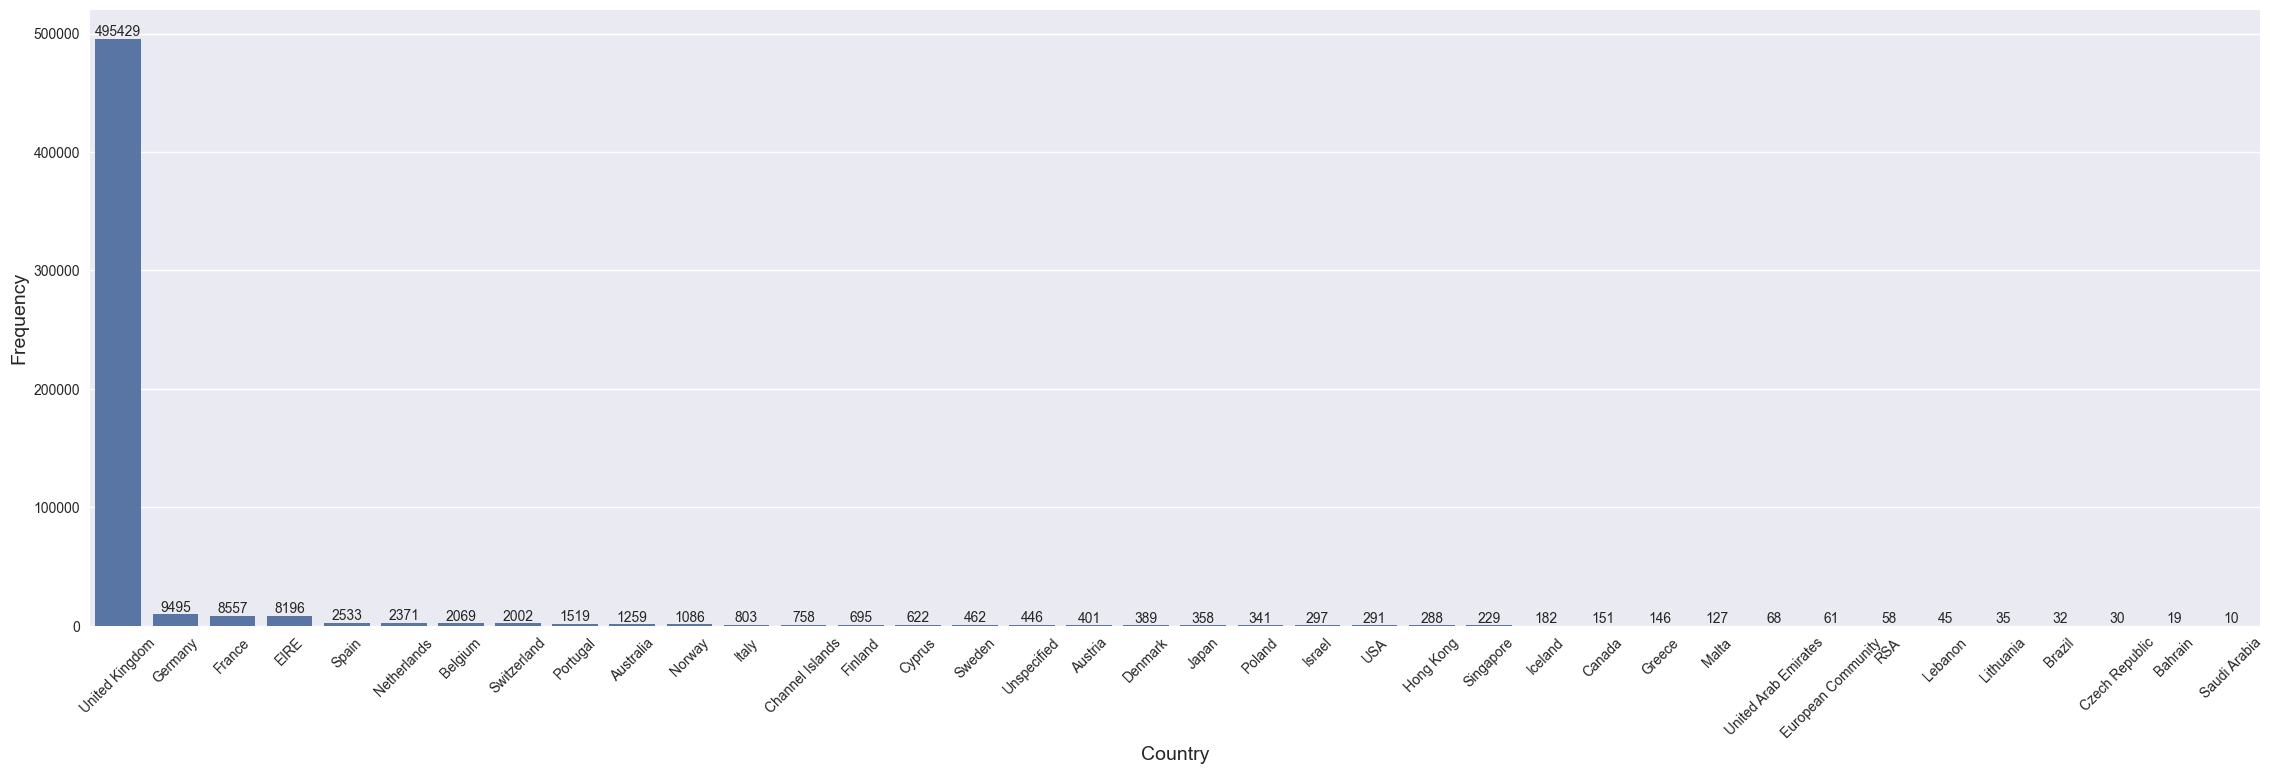

In [24]:
# Ploting them in a barchart
plt.figure(figsize= (28,8))
ax = sns.countplot(data = online_sales, x= 'Country', 
                    order= unique_countries_freq.index)
plt.title=('Frequency of Countries')
plt.xlabel('Country',fontsize=14)
plt.ylabel('Frequency',fontsize=14)
plt.xticks(rotation=45)
for i,freq in enumerate(unique_countries_freq):
    ax.text(i,freq+1,str(freq), ha='center', va='bottom',fontsize=10)
plt.show()

We can see from the barchart that United Kingdom is way more frequent than the other ones that we can neglect the others. so I am going to consider the timezone and holidays based on UK. For better visualization let plot them in horizontal barchart and as percentages as it is not well readable.

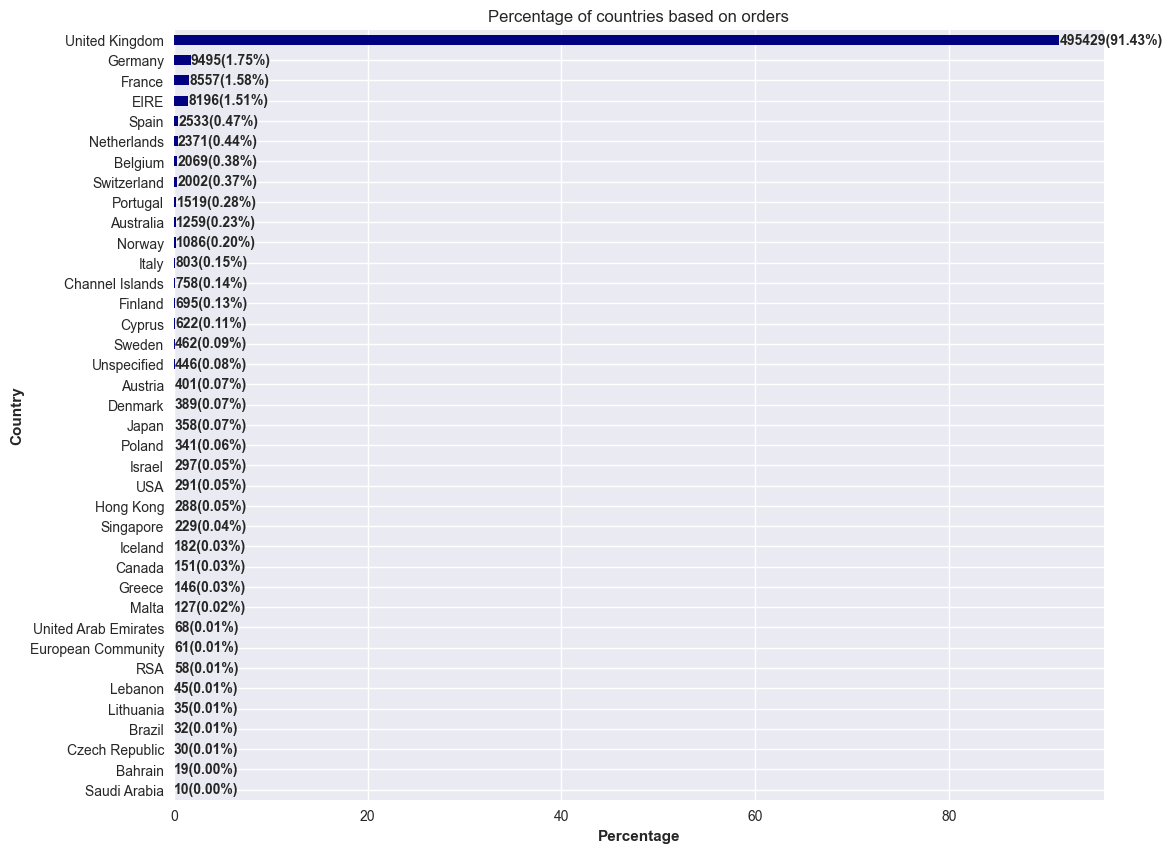

In [25]:
# horizontal bar chart
total_count = unique_countries_freq.sum()
# calculate percentages
percentages = (unique_countries_freq/total_count) * 100
# Plotting
plt.figure(figsize=(12,10))
ax= percentages.plot(kind='barh', color='navy',title='Percentage of countries based on orders')
plt.xlabel('Percentage', fontweight = 'bold')
plt.ylabel('Country',fontweight = 'bold')
# Adding value and percentages on each bar
for i,(country,freq) in enumerate(unique_countries_freq.items()):
    percent= percentages[country]
    ax.text(percent,i,f'{freq}({percent:.2f}%)',ha='left',va='center',fontsize=10,fontweight= 'bold')
plt.gca().invert_yaxis() # Inverting the y axis to have the highest frequency at the top
plt.show()

We can see that 91% of the entries are from UK and other percentages are so low less than 2%

In [26]:
online_sales.info()

<class 'pandas.core.frame.DataFrame'>
Index: 541860 entries, 2022-12-01 to 2023-12-09
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541860 non-null  object 
 1   StockCode    541860 non-null  object 
 2   Description  540406 non-null  object 
 3   Quantity     541860 non-null  int64  
 4   UnitPrice    541860 non-null  float64
 5   CustomerID   406827 non-null  float64
 6   Country      541860 non-null  object 
dtypes: float64(2), int64(1), object(4)
memory usage: 49.2+ MB


In [27]:
online_sales.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'UnitPrice',
       'CustomerID', 'Country'],
      dtype='object')

In [28]:
sk.skim(online_sales)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 541860 │ │ string      │ 4     │                                                          │
│ │ Number of columns │ 7      │ │ float64     │ 2     │                                                          │
│ └───────────────────┴────────┘ │ int32       │ 1     │                                                          │
│                                └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┓  │
│ ┃ column_name   ┃ NA       ┃ NA %   ┃ mean   ┃ sd    ┃ p0       ┃ p25    ┃ p50    ┃ p75    ┃ p100   ┃ hist   ┃  │
│ ┡━━━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━┩  │
│ │ Quantity      │        0 │      0 │    9.6 │   150 │   -74000 │      1 │      3 │     10 │  74000 │     ▇  │  │
│ │ UnitPrice     │        0 │      0 │    4.6 │    97 │   -11000 │    1.2 │    2.1 │    4.1 │  39000 │    ▇   │  │
│ │ CustomerID    │   135033 │  24.92 │  15000 │  1700 │    12000 │  14000 │  15000 │  17000 │  18000 │ ▇▆▇▆▆▇ │  │
│ └───────────────┴──────────┴────────┴────────┴───────┴──────────┴────────┴────────┴────────┴────────┴────────┘  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name              ┃ NA         ┃ NA %       ┃ words per row               ┃ total words             ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━┩  │
│ │ InvoiceNo                │          0 │          0 │                           1 │                  541860 │  │
│ │ StockCode                │          0 │          0 │                           1 │                  541897 │  │
│ │ Description              │       1454 │       0.27 │                         4.6 │                 2506804 │  │
│ │ Country                  │          0 │          0 │                         1.9 │                 1038572 │  │
│ └──────────────────────────┴────────────┴────────────┴─────────────────────────────┴─────────────────────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

In [29]:
online_sales.info()

<class 'pandas.core.frame.DataFrame'>
Index: 541860 entries, 2022-12-01 to 2023-12-09
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541860 non-null  object 
 1   StockCode    541860 non-null  object 
 2   Description  540406 non-null  object 
 3   Quantity     541860 non-null  int64  
 4   UnitPrice    541860 non-null  float64
 5   CustomerID   406827 non-null  float64
 6   Country      541860 non-null  object 
dtypes: float64(2), int64(1), object(4)
memory usage: 49.2+ MB


It has 541860 entries. We can see from the table that we have 7 number of columns, we already set the date as index. We saw previously quantity is int, invoice date is datetime and unit price is float.we should convert customer ID to string and I would set the NAs in customer ID (24.92% of the customer IDs are unknown) and description to 'Unknown'(27% of the data in description are unknown), as all of the columns except customer id and description don't have any NAs and the most important data is date, quantity and price which seems in good shape. I just add a category for those missing descriptive values to also be able to detect any patterns if exist. We also delete one cancelation entry with its origin as we detecting the minimums. Also deleted the rows with descriptions were they are equal to '?' (question marks) (47 rows)
Now let's handle missing values and negative values for quantity and unit price.

In [30]:
missing_values=online_sales.isna().sum()
missing_values

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
UnitPrice           0
CustomerID     135033
Country             0
dtype: int64

In [31]:
# First fill NA for customer ID and then convert it to text
online_sales['CustomerID'].fillna(9999, inplace=True)
online_sales['CustomerID']=online_sales['CustomerID'].astype('int') # I want to get rid of the .00 s
online_sales['CustomerID'].info()

<class 'pandas.core.series.Series'>
Index: 541860 entries, 2022-12-01 to 2023-12-09
Series name: CustomerID
Non-Null Count   Dtype
--------------   -----
541860 non-null  int32
dtypes: int32(1)
memory usage: 22.3+ MB


In [32]:
online_sales[online_sales['CustomerID']==9999]

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country
2022-12-01,536414,22139,NaN,56,0.00,9999,United Kingdom
2022-12-01,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,2.51,9999,United Kingdom
2022-12-01,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,2.51,9999,United Kingdom
2022-12-01,536544,21786,POLKADOT RAIN HAT,4,0.85,9999,United Kingdom
2022-12-01,536544,21787,RAIN PONCHO RETROSPOT,2,1.66,9999,United Kingdom
...,...,...,...,...,...,...,...
2023-12-09,581498,85099B,JUMBO BAG RED RETROSPOT,5,4.13,9999,United Kingdom
2023-12-09,581498,85099C,JUMBO BAG BAROQUE BLACK WHITE,4,4.13,9999,United Kingdom
2023-12-09,581498,85150,LADIES & GENTLEMEN METAL SIGN,1,4.96,9999,United Kingdom
2023-12-09,581498,85174,S/4 CACTI CANDLES,1,10.79,9999,United Kingdom


In [33]:

online_sales['CustomerID']=online_sales['CustomerID'].astype('str')
online_sales['CustomerID'].info()

<class 'pandas.core.series.Series'>
Index: 541860 entries, 2022-12-01 to 2023-12-09
Series name: CustomerID
Non-Null Count   Dtype 
--------------   ----- 
541860 non-null  object
dtypes: object(1)
memory usage: 24.4+ MB


In [34]:
online_sales['CustomerID'].replace('9999','Unknown', inplace=True)

In [35]:
online_sales[online_sales['CustomerID']=='Unknown']

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country
2022-12-01,536414,22139,NaN,56,0.00,Unknown,United Kingdom
2022-12-01,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,2.51,Unknown,United Kingdom
2022-12-01,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,2.51,Unknown,United Kingdom
2022-12-01,536544,21786,POLKADOT RAIN HAT,4,0.85,Unknown,United Kingdom
2022-12-01,536544,21787,RAIN PONCHO RETROSPOT,2,1.66,Unknown,United Kingdom
...,...,...,...,...,...,...,...
2023-12-09,581498,85099B,JUMBO BAG RED RETROSPOT,5,4.13,Unknown,United Kingdom
2023-12-09,581498,85099C,JUMBO BAG BAROQUE BLACK WHITE,4,4.13,Unknown,United Kingdom
2023-12-09,581498,85150,LADIES & GENTLEMEN METAL SIGN,1,4.96,Unknown,United Kingdom
2023-12-09,581498,85174,S/4 CACTI CANDLES,1,10.79,Unknown,United Kingdom


In [36]:
# Fill Missing Description with unknown
online_sales['Description'].fillna('Unknown',inplace=True)


In [37]:
online_sales[online_sales['Description']=='Unknown'].count()

InvoiceNo      1454
StockCode      1454
Description    1454
Quantity       1454
UnitPrice      1454
CustomerID     1454
Country        1454
dtype: int64

In [38]:
customer_unknown = online_sales[online_sales['Description']=='Unknown']
customer_unknown
# we keep in mind that all of the unit prices here are 0 


,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country
2022-12-01,536414,22139,Unknown,56,0.0,Unknown,United Kingdom
2022-12-01,536545,21134,Unknown,1,0.0,Unknown,United Kingdom
2022-12-01,536546,22145,Unknown,1,0.0,Unknown,United Kingdom
2022-12-01,536547,37509,Unknown,1,0.0,Unknown,United Kingdom
2022-12-01,536549,85226A,Unknown,1,0.0,Unknown,United Kingdom
...,...,...,...,...,...,...,...
2023-12-07,581199,84581,Unknown,-2,0.0,Unknown,United Kingdom
2023-12-07,581203,23406,Unknown,15,0.0,Unknown,United Kingdom
2023-12-07,581209,21620,Unknown,6,0.0,Unknown,United Kingdom
2023-12-08,581234,72817,Unknown,27,0.0,Unknown,United Kingdom


In [39]:
# which means we can delete them. But should check before deleting
customer_unknown['UnitPrice'].sum() 

0.0

After careful analysis, I will remove these rows as the unit price is 0.

In [40]:
# We gto rid of all of the missing values
missing_values=online_sales.isna().sum()
missing_values

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [41]:
online_sales[(online_sales['Description']=='Unknown') &(online_sales['CustomerID']=='Unknown') & (online_sales['UnitPrice']==0)].count()

InvoiceNo      1454
StockCode      1454
Description    1454
Quantity       1454
UnitPrice      1454
CustomerID     1454
Country        1454
dtype: int64

In [42]:
online_sales[(online_sales['CustomerID']=='Unknown')]

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country
2022-12-01,536414,22139,Unknown,56,0.00,Unknown,United Kingdom
2022-12-01,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,2.51,Unknown,United Kingdom
2022-12-01,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,2.51,Unknown,United Kingdom
2022-12-01,536544,21786,POLKADOT RAIN HAT,4,0.85,Unknown,United Kingdom
2022-12-01,536544,21787,RAIN PONCHO RETROSPOT,2,1.66,Unknown,United Kingdom
...,...,...,...,...,...,...,...
2023-12-09,581498,85099B,JUMBO BAG RED RETROSPOT,5,4.13,Unknown,United Kingdom
2023-12-09,581498,85099C,JUMBO BAG BAROQUE BLACK WHITE,4,4.13,Unknown,United Kingdom
2023-12-09,581498,85150,LADIES & GENTLEMEN METAL SIGN,1,4.96,Unknown,United Kingdom
2023-12-09,581498,85174,S/4 CACTI CANDLES,1,10.79,Unknown,United Kingdom


In [43]:
online_sales.info()

<class 'pandas.core.frame.DataFrame'>
Index: 541860 entries, 2022-12-01 to 2023-12-09
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541860 non-null  object 
 1   StockCode    541860 non-null  object 
 2   Description  541860 non-null  object 
 3   Quantity     541860 non-null  int64  
 4   UnitPrice    541860 non-null  float64
 5   CustomerID   541860 non-null  object 
 6   Country      541860 non-null  object 
dtypes: float64(1), int64(1), object(5)
memory usage: 49.2+ MB


In [44]:
# No missing values
sk.skim(online_sales)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 541860 │ │ string      │ 5     │                                                          │
│ │ Number of columns │ 7      │ │ int32       │ 1     │                                                          │
│ └───────────────────┴────────┘ │ float64     │ 1     │                                                          │
│                                └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━┳━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓  │
│ ┃ column_name      ┃ NA   ┃ NA %    ┃ mean   ┃ sd    ┃ p0        ┃ p25   ┃ p50   ┃ p75   ┃ p100    ┃ hist    ┃  │
│ ┡━━━━━━━━━━━━━━━━━━╇━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩  │
│ │ Quantity         │    0 │       0 │    9.6 │   150 │    -74000 │     1 │     3 │    10 │   74000 │     ▇   │  │
│ │ UnitPrice        │    0 │       0 │    4.6 │    97 │    -11000 │   1.2 │   2.1 │   4.1 │   39000 │    ▇    │  │
│ └──────────────────┴──────┴─────────┴────────┴───────┴───────────┴───────┴───────┴───────┴─────────┴─────────┘  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name               ┃ NA      ┃ NA %       ┃ words per row                ┃ total words              ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━┩  │
│ │ InvoiceNo                 │       0 │          0 │                            1 │                   541860 │  │
│ │ StockCode                 │       0 │          0 │                            1 │                   541897 │  │
│ │ Description               │       0 │          0 │                          4.6 │                  2508258 │  │
│ │ CustomerID                │       0 │          0 │                            1 │                   541860 │  │
│ │ Country                   │       0 │          0 │                          1.9 │                  1038572 │  │
│ └───────────────────────────┴─────────┴────────────┴──────────────────────────────┴──────────────────────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

Now we don't have missing values and the types are correct. What we can see from the quantity and price is that we have - values. It can be both because of canceled invoices or error in data. Let's look into them deeper:

In [45]:
# First let's detect canceled invoices and their order and remove those rows if possible
cancelled_invoices= online_sales[online_sales['InvoiceNo'].str.startswith('C')]
online_sales['Abs_Quantity']=online_sales['Quantity'].abs()
cancelled_invoices


,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country
2022-12-01,C536379,D,Discount,-1,27.50,14527,United Kingdom
2022-12-01,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,4.65,15311,United Kingdom
2022-12-01,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,1.65,17548,United Kingdom
2022-12-01,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,0.29,17548,United Kingdom
2022-12-01,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,0.29,17548,United Kingdom
...,...,...,...,...,...,...,...
2023-12-09,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,0.83,14397,United Kingdom
2023-12-09,C581499,M,Manual,-1,224.69,15498,United Kingdom
2023-12-09,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,10.95,15311,United Kingdom
2023-12-09,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,1.25,17315,United Kingdom


In [46]:
cancelled_invoices[cancelled_invoices['UnitPrice'] <= 0]
# THe Unit price is positive (just wonder if the negative unit price is the error that exists here as well)

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country


In [47]:
cancelled_invoices.reset_index(inplace=True)
cancelled_invoices=cancelled_invoices.rename(columns={'index':'InvoiceDate'})

In [48]:
online_sales_copy=online_sales.copy()


So, the numbers for invoices with C are unique(). So, we cannot find the original based on the number. Let's extract these cancelled invoices rom the original. 

In [49]:
# Extract the invoice number to check whether the invoice number without C is in the original dataset
cancelled_invoices_copy=cancelled_invoices.copy()
cancelled_invoices_copy['InvoiceNo']= cancelled_invoices_copy['InvoiceNo'].str.replace('^C','',regex=True)

In [50]:
cl_Invoice_orig=cancelled_invoices_copy['InvoiceNo'].isin(online_sales_copy['InvoiceNo'])
cl_Invoice_orig.sum()

0

In [51]:
online_sales_copy= online_sales_copy.reset_index().rename(columns={'index':'InvoiceDate'})

In [52]:
merged = cancelled_invoices.merge(online_sales_copy,on = ['InvoiceDate','CustomerID','StockCode','Description', 'UnitPrice'],
                         suffixes=('_cncl','_org'),
                         )
merged.drop_duplicates(inplace=True)

In [53]:
merged

,InvoiceDate,InvoiceNo_cncl,StockCode,Description,Quantity_cncl,UnitPrice,CustomerID,Country_cncl,InvoiceNo_org,Quantity_org,Country_org,Abs_Quantity
0,2022-12-01,C536379,D,Discount,-1,27.50,14527,United Kingdom,C536379,-1,United Kingdom,1
1,2022-12-01,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,4.65,15311,United Kingdom,C536383,-1,United Kingdom,1
2,2022-12-01,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,1.65,17548,United Kingdom,C536391,-12,United Kingdom,12
3,2022-12-01,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,0.29,17548,United Kingdom,C536391,-24,United Kingdom,24
4,2022-12-01,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,0.29,17548,United Kingdom,C536391,-24,United Kingdom,24
...,...,...,...,...,...,...,...,...,...,...,...,...
11117,2023-12-09,C581499,M,Manual,-1,224.69,15498,United Kingdom,C581499,-1,United Kingdom,1
11118,2023-12-09,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,10.95,15311,United Kingdom,C581568,-5,United Kingdom,5
11119,2023-12-09,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,10.95,15311,United Kingdom,581571,8,United Kingdom,8
11120,2023-12-09,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,1.25,17315,United Kingdom,C581569,-1,United Kingdom,1


In [54]:
merged_filtered =merged[merged['InvoiceNo_cncl'] != merged['InvoiceNo_org']]

In [55]:
merged_filtered

,InvoiceDate,InvoiceNo_cncl,StockCode,Description,Quantity_cncl,UnitPrice,CustomerID,Country_cncl,InvoiceNo_org,Quantity_org,Country_org,Abs_Quantity
9,2022-12-01,C536506,22960,JAM MAKING SET WITH JARS,-6,4.25,17897,United Kingdom,536488,8,United Kingdom,8
36,2022-12-02,C536758,21314,SMALL GLASS HEART TRINKET POT,-1,2.10,13767,United Kingdom,536794,24,United Kingdom,24
62,2022-12-02,C536820,21843,RED RETROSPOT CAKE STAND,-1,10.95,18168,United Kingdom,536836,2,United Kingdom,2
90,2022-12-05,C537039,22854,CREAM SWEETHEART EGG HOLDER,-1,4.95,15708,United Kingdom,537051,2,United Kingdom,2
92,2022-12-05,C537039,20936,FORKED CACTUS CANDLE,-1,2.95,15708,United Kingdom,537051,6,United Kingdom,6
...,...,...,...,...,...,...,...,...,...,...,...,...
11040,2023-12-07,C581178,23079,TOADSTOOL BEDSIDE LIGHT,-1,8.95,15525,United Kingdom,581166,1,United Kingdom,1
11043,2023-12-07,C581178,23494,VINTAGE DOILY DELUXE SEWING KIT,-1,5.95,15525,United Kingdom,581166,1,United Kingdom,1
11075,2023-12-08,C581330,22959,WRAP CHRISTMAS VILLAGE,-25,0.42,15877,United Kingdom,581325,25,United Kingdom,25
11077,2023-12-08,C581330,16169E,WRAP 50'S CHRISTMAS,-100,0.42,15877,United Kingdom,581325,100,United Kingdom,100


ok. As this merge is prone to mistake and we don't have enough data to prove that the cancelation and original order have the same quantity, in order to make it easier I would simply sum and multiply them for profit considering the -signes as they cancel out and no mistake will be made.

Now, we have no NAs and we should get rid of the negative values in price.Let's analyze it.

In [56]:
sk.skim(online_sales)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 541860 │ │ string      │ 5     │                                                          │
│ │ Number of columns │ 8      │ │ int32       │ 2     │                                                          │
│ └───────────────────┴────────┘ │ float64     │ 1     │                                                          │
│                                └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓  │
│ ┃ column_name       ┃ NA   ┃ NA %   ┃ mean   ┃ sd    ┃ p0        ┃ p25   ┃ p50   ┃ p75   ┃ p100    ┃ hist    ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩  │
│ │ Quantity          │    0 │      0 │    9.6 │   150 │    -74000 │     1 │     3 │    10 │   74000 │     ▇   │  │
│ │ UnitPrice         │    0 │      0 │    4.6 │    97 │    -11000 │   1.2 │   2.1 │   4.1 │   39000 │    ▇    │  │
│ │ Abs_Quantity      │    0 │      0 │     11 │   150 │         1 │     1 │     3 │    10 │   74000 │    ▇    │  │
│ └───────────────────┴──────┴────────┴────────┴───────┴───────────┴───────┴───────┴───────┴─────────┴─────────┘  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name               ┃ NA      ┃ NA %       ┃ words per row                ┃ total words              ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━┩  │
│ │ InvoiceNo                 │       0 │          0 │                            1 │                   541860 │  │
│ │ StockCode                 │       0 │          0 │                            1 │                   541897 │  │
│ │ Description               │       0 │          0 │                          4.6 │                  2508258 │  │
│ │ CustomerID                │       0 │          0 │                            1 │                   541860 │  │
│ │ Country                   │       0 │          0 │                          1.9 │                  1038572 │  │
│ └───────────────────────────┴─────────┴────────────┴──────────────────────────────┴──────────────────────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

In [57]:
# Let's see the negative values in Quantity and Unit price : Quantity can be due to cancelations but unit price shouldn't be negative
# Unit_price
online_sales[online_sales['UnitPrice']<0]

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,Abs_Quantity
2023-08-12,A563186,B,Adjust bad debt,1,-11062.06,Unknown,United Kingdom,1
2023-08-12,A563187,B,Adjust bad debt,1,-11062.06,Unknown,United Kingdom,1


These negative values are due to bad debt which is I think should be calculated in the profit. Based on the description I don't want to get rid of these columns.

In [58]:
# let's see the negative values in quantity that doesn't correspond to the cancellations
negative_quantity = online_sales[(online_sales['Quantity']<0)]
negative_quantity

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,Abs_Quantity
2022-12-01,C536379,D,Discount,-1,27.50,14527,United Kingdom,1
2022-12-01,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,4.65,15311,United Kingdom,1
2022-12-01,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,1.65,17548,United Kingdom,12
2022-12-01,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,0.29,17548,United Kingdom,24
2022-12-01,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,0.29,17548,United Kingdom,24
...,...,...,...,...,...,...,...,...
2023-12-09,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,0.83,14397,United Kingdom,11
2023-12-09,C581499,M,Manual,-1,224.69,15498,United Kingdom,1
2023-12-09,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,10.95,15311,United Kingdom,5
2023-12-09,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,1.25,17315,United Kingdom,1


In [59]:
# Cancellation invoices only
negative_quantity_with_cncl = online_sales[(online_sales['Quantity']<0) & (online_sales['InvoiceNo'].str.startswith('C') )]
negative_quantity_with_cncl

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,Abs_Quantity
2022-12-01,C536379,D,Discount,-1,27.50,14527,United Kingdom,1
2022-12-01,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,4.65,15311,United Kingdom,1
2022-12-01,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,1.65,17548,United Kingdom,12
2022-12-01,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,0.29,17548,United Kingdom,24
2022-12-01,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,0.29,17548,United Kingdom,24
...,...,...,...,...,...,...,...,...
2023-12-09,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,0.83,14397,United Kingdom,11
2023-12-09,C581499,M,Manual,-1,224.69,15498,United Kingdom,1
2023-12-09,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,10.95,15311,United Kingdom,5
2023-12-09,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,1.25,17315,United Kingdom,1


In [60]:
# out of 9762 invoices with negative quantity 9288 are for cancellations. let's see the rest:
filtered_data= negative_quantity[~negative_quantity['InvoiceNo'].str.startswith('C')]
filtered_data

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,Abs_Quantity
2022-12-01,536589,21777,Unknown,-10,0.0,Unknown,United Kingdom,10
2022-12-02,536764,84952C,Unknown,-38,0.0,Unknown,United Kingdom,38
2022-12-03,536996,22712,Unknown,-20,0.0,Unknown,United Kingdom,20
2022-12-03,536997,22028,Unknown,-20,0.0,Unknown,United Kingdom,20
2022-12-03,536998,85067,Unknown,-6,0.0,Unknown,United Kingdom,6
...,...,...,...,...,...,...,...,...
2023-12-07,581210,23395,check,-26,0.0,Unknown,United Kingdom,26
2023-12-07,581212,22578,lost,-1050,0.0,Unknown,United Kingdom,1050
2023-12-07,581213,22576,check,-30,0.0,Unknown,United Kingdom,30
2023-12-08,581226,23090,missing,-338,0.0,Unknown,United Kingdom,338


In [61]:
filtered_data['UnitPrice'].unique()

array([0.])

In [62]:
filtered_data['Description'].unique()

array(['Unknown', 'check', 'damages', 'faulty', 'Dotcom sales',
       'reverse 21/5/10 adjustment', 'mouldy, thrown away.', 'counted',
       'Given away', 'Dotcom', 'label mix up', 'samples/damages',
       'thrown away', 'incorrectly made-thrown away.', 'showroom', 'MIA',
       'Dotcom set', 'wrongly sold as sets', 'Amazon sold sets',
       'dotcom sold sets', 'wrongly sold sets', '? sold as sets?',
       '?sold as sets?', 'Thrown away.', 'damages/display',
       'damaged stock', 'broken', 'throw away', 'wrong barcode (22467)',
       'wrong barcode', 'barcode problem', '?lost',
       "thrown away-can't sell.", "thrown away-can't sell", 'damages?',
       're dotcom quick fix.', "Dotcom sold in 6's", 'sold in set?',
       'cracked', 'sold as 22467', 'Damaged',
       'mystery! Only ever imported 1800',
       'MERCHANT CHANDLER CREDIT ERROR, STO', 'POSSIBLE DAMAGES OR LOST?',
       'damaged', 'DAMAGED', 'Display', 'Missing', 'wrong code?',
       'wrong code', 'adjust', 'crus

In [63]:
filtered_data['CustomerID'].unique()

array(['Unknown'], dtype=object)

 all the prices are zero. all of them are recorded as  missing or faulty or incorrect, rusty, damaged lost... mistake on the stock part. It is useful for stock. Where we have 0 for unit price We can set the unit price based on the stock number in other invoices as based on the problem description in the powerpoint of the problem, stock code is a 5-digit integral number uniquely assigned to each distinct product. It seems that all of the customerIDs are unknown so we can conclude that this data is entered by sales staff or other internal entities. I am going to do the following:
1. substitute the unitprice with the price of the stock in the original dataset.
2. Substitute the unknown with Unknown_faulty
3. Then we can move on to adding the profit column and start time series analysis

In [64]:
filtered_data.reset_index()

,index,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,Abs_Quantity
0,2022-12-01,536589,21777,Unknown,-10,0.0,Unknown,United Kingdom,10
1,2022-12-02,536764,84952C,Unknown,-38,0.0,Unknown,United Kingdom,38
2,2022-12-03,536996,22712,Unknown,-20,0.0,Unknown,United Kingdom,20
3,2022-12-03,536997,22028,Unknown,-20,0.0,Unknown,United Kingdom,20
4,2022-12-03,536998,85067,Unknown,-6,0.0,Unknown,United Kingdom,6
...,...,...,...,...,...,...,...,...,...
1290,2023-12-07,581210,23395,check,-26,0.0,Unknown,United Kingdom,26
1291,2023-12-07,581212,22578,lost,-1050,0.0,Unknown,United Kingdom,1050
1292,2023-12-07,581213,22576,check,-30,0.0,Unknown,United Kingdom,30
1293,2023-12-08,581226,23090,missing,-338,0.0,Unknown,United Kingdom,338


In [65]:
online_sales.reset_index()

,index,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,Abs_Quantity
0,2022-12-01,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850,United Kingdom,6
1,2022-12-01,536365,71053,WHITE METAL LANTERN,6,3.39,17850,United Kingdom,6
2,2022-12-01,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,17850,United Kingdom,8
3,2022-12-01,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,17850,United Kingdom,6
4,2022-12-01,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,17850,United Kingdom,6
...,...,...,...,...,...,...,...,...,...
541855,2023-12-09,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,0.85,12680,France,12
541856,2023-12-09,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2.10,12680,France,6
541857,2023-12-09,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,4.15,12680,France,4
541858,2023-12-09,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,4.15,12680,France,4


In [66]:
online_sales[online_sales['UnitPrice'] == 0]

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,Abs_Quantity
2022-12-01,536414,22139,Unknown,56,0.0,Unknown,United Kingdom,56
2022-12-01,536545,21134,Unknown,1,0.0,Unknown,United Kingdom,1
2022-12-01,536546,22145,Unknown,1,0.0,Unknown,United Kingdom,1
2022-12-01,536547,37509,Unknown,1,0.0,Unknown,United Kingdom,1
2022-12-01,536549,85226A,Unknown,1,0.0,Unknown,United Kingdom,1
...,...,...,...,...,...,...,...,...
2023-12-08,581234,72817,Unknown,27,0.0,Unknown,United Kingdom,27
2023-12-08,581406,46000M,POLYESTER FILLER PAD 45x45cm,240,0.0,Unknown,United Kingdom,240
2023-12-08,581406,46000S,POLYESTER FILLER PAD 40x40cm,300,0.0,Unknown,United Kingdom,300
2023-12-08,581408,85175,Unknown,20,0.0,Unknown,United Kingdom,20


In [67]:
stock_prices = online_sales.set_index('StockCode')['UnitPrice'].to_dict
stock_prices

<bound method Series.to_dict of StockCode
85123A    2.55
71053     3.39
84406B    2.75
84029G    3.39
84029E    3.39
          ... 
22613     0.85
22899     2.10
23254     4.15
23255     4.15
22138     4.95
Name: UnitPrice, Length: 541860, dtype: float64>

In [68]:
# For each stockCode we have various unitprices for different countries, in different dates and based on the quantity.
duplicate_prices = online_sales[online_sales.duplicated(subset=['StockCode','UnitPrice'])]
duplicate_prices.sort_values(by='StockCode')

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,Abs_Quantity
2023-01-23,541849,10002,INFLATABLE POLITICAL GLOBE,2,0.85,13230,United Kingdom,2
2023-03-04,545637,10002,INFLATABLE POLITICAL GLOBE,2,0.85,15514,United Kingdom,2
2023-01-06,540277,10002,INFLATABLE POLITICAL GLOBE,60,0.85,14258,United Kingdom,60
2023-01-05,540239,10002,INFLATABLE POLITICAL GLOBE,12,0.85,12682,France,12
2023-03-17,546790,10002,INFLATABLE POLITICAL GLOBE,6,0.85,14713,United Kingdom,6
...,...,...,...,...,...,...,...,...
2023-02-18,544434,gift_0001_30,Dotcomgiftshop Gift Voucher £30.00,1,25.00,Unknown,United Kingdom,1
2023-08-30,564760,gift_0001_30,Dotcomgiftshop Gift Voucher £30.00,1,25.00,Unknown,United Kingdom,1
2023-07-27,561513,gift_0001_40,Dotcomgiftshop Gift Voucher £40.00,1,33.33,Unknown,United Kingdom,1
2023-06-24,558066,gift_0001_50,Dotcomgiftshop Gift Voucher £50.00,1,41.67,Unknown,United Kingdom,1


In [69]:
online_sales[online_sales['UnitPrice'] == 0].shape[0]

2468

In [70]:
#as we have different prices for different countries 
# and with different quantities and different dates,
#I would use the mean value to keep it safe
stock_prices=online_sales.groupby('StockCode')['UnitPrice'].mean().round(2). to_dict()


In [71]:
mask = (online_sales['Quantity'] < 0) & (online_sales['UnitPrice'] == 0.0)

online_sales[mask].shape[0]

1295

In [72]:
online_sales[mask]

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,Abs_Quantity
2022-12-01,536589,21777,Unknown,-10,0.0,Unknown,United Kingdom,10
2022-12-02,536764,84952C,Unknown,-38,0.0,Unknown,United Kingdom,38
2022-12-03,536996,22712,Unknown,-20,0.0,Unknown,United Kingdom,20
2022-12-03,536997,22028,Unknown,-20,0.0,Unknown,United Kingdom,20
2022-12-03,536998,85067,Unknown,-6,0.0,Unknown,United Kingdom,6
...,...,...,...,...,...,...,...,...
2023-12-07,581210,23395,check,-26,0.0,Unknown,United Kingdom,26
2023-12-07,581212,22578,lost,-1050,0.0,Unknown,United Kingdom,1050
2023-12-07,581213,22576,check,-30,0.0,Unknown,United Kingdom,30
2023-12-08,581226,23090,missing,-338,0.0,Unknown,United Kingdom,338


In [73]:
online_sales.loc[mask, 'UnitPrice'] = online_sales.loc[mask, 'StockCode'].map(stock_prices)
online_sales[(online_sales['UnitPrice'] == 0) & (online_sales['Quantity'] < 0 )]
# It seems that for some negative quantities without UnitPrice we don't have the stock price. 
# So I am going to remove them as we cannot calculate the sales revenue from them

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,Abs_Quantity
2022-12-03,537001,21653,Unknown,-6,0.0,Unknown,United Kingdom,6
2022-12-10,538241,21431,Unknown,-21,0.0,Unknown,United Kingdom,21
2023-01-10,540560,21589,Unknown,-14,0.0,Unknown,United Kingdom,14
2023-01-10,540638,72038P,damages,-990,0.0,Unknown,United Kingdom,990
2023-01-10,540683,84546,Unknown,-45,0.0,Unknown,United Kingdom,45
...,...,...,...,...,...,...,...,...
2023-10-31,573592,79323GR,"Unsaleable, destroyed.",-1158,0.0,Unknown,United Kingdom,1158
2023-10-31,573593,79323LP,"Unsaleable, destroyed.",-2618,0.0,Unknown,United Kingdom,2618
2023-10-31,573595,79323S,"Unsaleable, destroyed.",-674,0.0,Unknown,United Kingdom,674
2023-10-31,573597,79341,"Unsaleable, destroyed.",-905,0.0,Unknown,United Kingdom,905


In [74]:
online_sales[online_sales['StockCode'] == 'DCGS0073']

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,Abs_Quantity
2023-07-26,561249,DCGS0073,ebay,-4,0.0,Unknown,United Kingdom,4


In [75]:
online_sales.loc[mask,'UnitPrice'] 

2022-12-01     6.36
2022-12-02     3.50
2022-12-03     0.54
2022-12-03     0.54
2022-12-03    13.25
              ...  
2023-12-07     4.82
2023-12-07     0.47
2023-12-07     1.08
2023-12-08     0.97
2023-12-08     4.63
Name: UnitPrice, Length: 1295, dtype: float64

In [76]:
online_sales[(online_sales['UnitPrice'] == 0) ].shape[0]

1288

In [77]:
unchanged = online_sales[(online_sales['UnitPrice'] == 0) & (online_sales['Quantity'] < 0.0)]
unchanged

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,Abs_Quantity
2022-12-03,537001,21653,Unknown,-6,0.0,Unknown,United Kingdom,6
2022-12-10,538241,21431,Unknown,-21,0.0,Unknown,United Kingdom,21
2023-01-10,540560,21589,Unknown,-14,0.0,Unknown,United Kingdom,14
2023-01-10,540638,72038P,damages,-990,0.0,Unknown,United Kingdom,990
2023-01-10,540683,84546,Unknown,-45,0.0,Unknown,United Kingdom,45
...,...,...,...,...,...,...,...,...
2023-10-31,573592,79323GR,"Unsaleable, destroyed.",-1158,0.0,Unknown,United Kingdom,1158
2023-10-31,573593,79323LP,"Unsaleable, destroyed.",-2618,0.0,Unknown,United Kingdom,2618
2023-10-31,573595,79323S,"Unsaleable, destroyed.",-674,0.0,Unknown,United Kingdom,674
2023-10-31,573597,79341,"Unsaleable, destroyed.",-905,0.0,Unknown,United Kingdom,905


In [78]:
# Remove the rest of rows with negative quantity and 0 price per unit
online_sales=online_sales[~((online_sales['Quantity'] < 0) & (online_sales['UnitPrice'] == 0))]

In [79]:
online_sales[(online_sales['UnitPrice'] == 0) & (online_sales['Quantity'] < 0)]

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,Abs_Quantity


In [80]:
online_sales[(online_sales['UnitPrice'] == 0)]

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,Abs_Quantity
2022-12-01,536414,22139,Unknown,56,0.0,Unknown,United Kingdom,56
2022-12-01,536545,21134,Unknown,1,0.0,Unknown,United Kingdom,1
2022-12-01,536546,22145,Unknown,1,0.0,Unknown,United Kingdom,1
2022-12-01,536547,37509,Unknown,1,0.0,Unknown,United Kingdom,1
2022-12-01,536549,85226A,Unknown,1,0.0,Unknown,United Kingdom,1
...,...,...,...,...,...,...,...,...
2023-12-07,581211,22142,check,14,0.0,Unknown,United Kingdom,14
2023-12-08,581234,72817,Unknown,27,0.0,Unknown,United Kingdom,27
2023-12-08,581406,46000M,POLYESTER FILLER PAD 45x45cm,240,0.0,Unknown,United Kingdom,240
2023-12-08,581406,46000S,POLYESTER FILLER PAD 40x40cm,300,0.0,Unknown,United Kingdom,300


In [81]:
# this is the list of stock prices, where we have large quantities and from various countries this stock prices changes, for this 
# for this reason it quals to means of all the same stockcodes, as I did on the above section before
stock_prices

{'10002': 1.06,
 '10080': 0.38,
 '10120': 0.21,
 '10123C': 0.49,
 '10123G': 0.0,
 '10124A': 0.42,
 '10124G': 0.42,
 '10125': 0.86,
 '10133': 0.65,
 '10134': 0.0,
 '10135': 1.41,
 '11001': 1.88,
 '15030': 0.27,
 '15034': 0.37,
 '15036': 1.06,
 '15039': 1.23,
 '15044A': 3.66,
 '15044B': 3.44,
 '15044C': 3.82,
 '15044D': 3.32,
 '15056BL': 6.42,
 '15056N': 6.93,
 '15056P': 6.33,
 '15056bl': 12.49,
 '15056n': 12.48,
 '15056p': 12.5,
 '15058A': 8.94,
 '15058B': 9.74,
 '15058C': 9.21,
 '15060B': 4.91,
 '15060b': 8.29,
 '16008': 0.13,
 '16010': 0.09,
 '16011': 0.21,
 '16012': 0.21,
 '16014': 0.4,
 '16015': 0.43,
 '16016': 0.85,
 '16020C': 0.75,
 '16033': 0.1,
 '16043': 0.08,
 '16045': 0.04,
 '16046': 0.8,
 '16048': 0.33,
 '16049': 0.17,
 '16052': 0.55,
 '16053': 0.0,
 '16054': 0.13,
 '16151A': 0.94,
 '16156L': 0.42,
 '16156S': 0.41,
 '16161G': 0.1,
 '16161M': 0.42,
 '16161P': 0.42,
 '16161U': 0.42,
 '16162L': 0.52,
 '16162M': 0.34,
 '16168M': 0.62,
 '16169E': 0.42,
 '16169K': 0.37,
 '16169M': 

In [82]:
mask_unit_zero= (online_sales['UnitPrice'] == 0.0)
online_sales.loc[mask_unit_zero, 'UnitPrice'] = online_sales.loc[mask_unit_zero, 'StockCode'].map(stock_prices)


In [83]:
online_sales[(online_sales['UnitPrice'] == 0)]

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,Abs_Quantity
2022-12-01,536545,21134,Unknown,1,0.0,Unknown,United Kingdom,1
2022-12-01,536549,85226A,Unknown,1,0.0,Unknown,United Kingdom,1
2022-12-01,536550,85044,Unknown,1,0.0,Unknown,United Kingdom,1
2022-12-01,536552,20950,Unknown,1,0.0,Unknown,United Kingdom,1
2022-12-01,536554,84670,Unknown,23,0.0,Unknown,United Kingdom,23
2022-12-03,536995,35951,Unknown,57,0.0,Unknown,United Kingdom,57
2022-12-08,537875,20849,Unknown,1,0.0,Unknown,United Kingdom,1
2022-12-08,537878,72803B,Unknown,1,0.0,Unknown,United Kingdom,1
2022-12-09,538133,85018C,Unknown,3,0.0,Unknown,United Kingdom,3
2022-12-09,538137,62095B,Unknown,2,0.0,Unknown,United Kingdom,2


As there is no stockcode with unitprice other than 0 for the stocks above, I am going to remove them.

In [84]:
# Remove those 4 rows
online_sales=online_sales[~(online_sales['UnitPrice'] == 0)]

In [85]:
online_sales[(online_sales['UnitPrice'] == 0)]

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,Abs_Quantity


In [86]:
sk.skim(online_sales)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 541725 │ │ string      │ 5     │                                                          │
│ │ Number of columns │ 8      │ │ int32       │ 2     │                                                          │
│ └───────────────────┴────────┘ │ float64     │ 1     │                                                          │
│                                └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓  │
│ ┃ column_name       ┃ NA   ┃ NA %   ┃ mean   ┃ sd    ┃ p0        ┃ p25   ┃ p50   ┃ p75   ┃ p100    ┃ hist    ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩  │
│ │ Quantity          │    0 │      0 │    9.6 │   150 │    -74000 │     1 │     3 │    10 │   74000 │     ▇   │  │
│ │ UnitPrice         │    0 │      0 │    4.6 │    97 │    -11000 │   1.2 │   2.1 │   4.1 │   39000 │    ▇    │  │
│ │ Abs_Quantity      │    0 │      0 │     11 │   150 │         1 │     1 │     3 │    10 │   74000 │    ▇    │  │
│ └───────────────────┴──────┴────────┴────────┴───────┴───────────┴───────┴───────┴───────┴─────────┴─────────┘  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name               ┃ NA      ┃ NA %       ┃ words per row                ┃ total words              ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━┩  │
│ │ InvoiceNo                 │       0 │          0 │                            1 │                   541725 │  │
│ │ StockCode                 │       0 │          0 │                            1 │                   541762 │  │
│ │ Description               │       0 │          0 │                          4.6 │                  2508099 │  │
│ │ CustomerID                │       0 │          0 │                            1 │                   541725 │  │
│ │ Country                   │       0 │          0 │                          1.9 │                  1038302 │  │
│ └───────────────────────────┴─────────┴────────────┴──────────────────────────────┴──────────────────────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

In [87]:
online_sales.describe()

,Quantity,UnitPrice,Abs_Quantity
count,541725.000000,541725.000000,541725.000000
mean,9.594863,4.635307,10.970107
std,152.299039,96.787337,152.206161
min,-74215.000000,-11062.060000,1.000000
25%,1.000000,1.250000,1.000000
50%,3.000000,2.080000,3.000000
75%,10.000000,4.130000,10.000000
max,74215.000000,38970.000000,74215.000000


In [88]:
# B

What we did so far:
0. Import with InvoiceDate conversion to datetime
1. removed the NAs in description and CustomerID with Unknown
2. converted customerID to string
3. Decided not to remove the rows with unknown description and unknown customer ID as all of them have quantity without price per unit
4. Then I checked the negative values for unit price which was due to adjustment for debt which I keep as it is.
5. I checked for negative quantities which based on description were lost, or damdaged or some faulty thing happened so based on a reason they were accounted as loss which is logical I decided to keep them 
6. I decided to check the stockcode and replace the 0 in price per unit for the negative quantities with the related stock price for that stock code, but as there are different stock prices based on the country and quantity and date of the invoice I decided to put the mean for those cases.
7. After the above step, I got some rows without replacement which means they are the only unit price which is zero. So, I remove them as the target at the end is to predict the sales revenue.
8. Then I checked the remaining unitprices=0 and replaced the stock prices the same way as the above.
9. Then I removed the remaining zeros that don't have stockcode price other than 0
Now we have the data without missing values and errors and correct and to some extent neat.However, first we should check the duplicates and then  investigate on outliers. Let's start the timeseries usuals :

In [89]:
# Check the dataframe
display(online_sales)


,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,Abs_Quantity
2022-12-01,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850,United Kingdom,6
2022-12-01,536365,71053,WHITE METAL LANTERN,6,3.39,17850,United Kingdom,6
2022-12-01,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,17850,United Kingdom,8
2022-12-01,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,17850,United Kingdom,6
2022-12-01,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,17850,United Kingdom,6
...,...,...,...,...,...,...,...,...
2023-12-09,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,0.85,12680,France,12
2023-12-09,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2.10,12680,France,6
2023-12-09,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,4.15,12680,France,4
2023-12-09,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,4.15,12680,France,4


In [90]:
# Drop Duplicates
online_sales_copy=online_sales.copy()
online_sales_copy=online_sales_copy.reset_index()
display(online_sales_copy)
display(online_sales_copy.shape[0])
# drop exact duplicates
online_sales_copy = online_sales_copy.drop_duplicates(keep='first')

# set index back to original
online_sales_copy.set_index('index', inplace=True)
display(online_sales_copy)
display(online_sales_copy.shape[0])
# It is ok so I am going to set the original dataset to the copy
online_sales = online_sales_copy
display(online_sales[online_sales.duplicated()].describe(include='object'))

,index,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,Abs_Quantity
0,2022-12-01,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850,United Kingdom,6
1,2022-12-01,536365,71053,WHITE METAL LANTERN,6,3.39,17850,United Kingdom,6
2,2022-12-01,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,17850,United Kingdom,8
3,2022-12-01,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,17850,United Kingdom,6
4,2022-12-01,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,17850,United Kingdom,6
...,...,...,...,...,...,...,...,...,...
541720,2023-12-09,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,0.85,12680,France,12
541721,2023-12-09,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2.10,12680,France,6
541722,2023-12-09,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,4.15,12680,France,4
541723,2023-12-09,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,4.15,12680,France,4


541725

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,Abs_Quantity
index,,,,,,,,
2022-12-01,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850,United Kingdom,6
2022-12-01,536365,71053,WHITE METAL LANTERN,6,3.39,17850,United Kingdom,6
2022-12-01,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,17850,United Kingdom,8
2022-12-01,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,17850,United Kingdom,6
2022-12-01,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,17850,United Kingdom,6
...,...,...,...,...,...,...,...,...
2023-12-09,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,0.85,12680,France,12
2023-12-09,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2.10,12680,France,6
2023-12-09,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,4.15,12680,France,4


536456

,InvoiceNo,StockCode,Description,CustomerID,Country
count,0,0,0,0,0
unique,0,0,0,0,0
top,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN


We already have the InvoiceDate as index.Let's add the sales revenue for profit and as we want to predict daily, aggregate by date

In [91]:
online_sales['Sales_Revenue'] = online_sales['Quantity'] * online_sales['UnitPrice']

In [92]:
online_sales

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,Abs_Quantity,Sales_Revenue
index,,,,,,,,,
2022-12-01,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850,United Kingdom,6,15.30
2022-12-01,536365,71053,WHITE METAL LANTERN,6,3.39,17850,United Kingdom,6,20.34
2022-12-01,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,17850,United Kingdom,8,22.00
2022-12-01,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,17850,United Kingdom,6,20.34
2022-12-01,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,17850,United Kingdom,6,20.34
...,...,...,...,...,...,...,...,...,...
2023-12-09,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,0.85,12680,France,12,10.20
2023-12-09,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2.10,12680,France,6,12.60
2023-12-09,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,4.15,12680,France,4,16.60


In [93]:
# Let's resample by Day and Profit per day 
daily_profit_online_sales= online_sales[['Sales_Revenue']].copy()
daily_profit_online_sales.index=pd.to_datetime(daily_profit_online_sales.index)
daily_profit_online_sales= daily_profit_online_sales.resample('D').sum()
display(daily_profit_online_sales)

,Sales_Revenue
index,
2022-12-01,58709.27
2022-12-02,46021.82
2022-12-03,42847.67
2022-12-04,0.00
2022-12-05,30982.01
...,...
2023-12-05,56480.62
2023-12-06,53535.94
2023-12-07,71500.46


In [94]:
sk.skim(daily_profit_online_sales)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 374    │ │ float64     │ 1     │                                                          │
│ │ Number of columns │ 1      │ └─────────────┴───────┘                                                          │
│ └───────────────────┴────────┘                                                                                  │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━┳━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓  │
│ ┃ column_name      ┃ NA  ┃ NA %   ┃ mean    ┃ sd     ┃ p0     ┃ p25    ┃ p50    ┃ p75    ┃ p100    ┃ hist    ┃  │
│ ┡━━━━━━━━━━━━━━━━━━╇━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩  │
│ │ Sales_Revenue    │   0 │      0 │   26000 │  25000 │  -9200 │  10000 │  24000 │  37000 │  310000 │   ▇▂    │  │
│ └──────────────────┴─────┴────────┴─────────┴────────┴────────┴────────┴────────┴────────┴─────────┴─────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

We can see that the rows are 374 days of entry stariting from 2022-12-01 till 2023-12-09 which means we have an entry for each day even when the revenue is 0.The min reveneue is -9200 and the max is 310000. We are going to look into these:

In [95]:
daily_profit_online_sales.describe()

,Sales_Revenue
count,374.000000
mean,26381.323139
std,25255.713907
min,-9226.690000
25%,10120.662500
50%,24140.555000
75%,36866.785000
max,310411.220000


In [96]:
# Let's plot the sales_revenue vs time
unique_months= daily_profit_online_sales.index.to_period('M').unique()
fig = px.line(daily_profit_online_sales,x=daily_profit_online_sales.index,y='Sales_Revenue', 
              title = '<b>Daily Revenue flow over time</b>'
)
fig.update_layout(yaxis_title = 'Sales Revenue')
fig.update_xaxes(tickmode='array',tickvals= unique_months.to_timestamp(), tickangle=45)
# I want to see the rolling mean for all the data from the last year December as well
first_index=daily_profit_online_sales.index[0]
# add rolling mean trend
rolling_mean = daily_profit_online_sales['Sales_Revenue'][first_index:].rolling(window=30).mean()
std_dev=daily_profit_online_sales['Sales_Revenue'][first_index:].rolling(window=30).std()
fig.add_trace(go.Scatter(x=daily_profit_online_sales.index, y=rolling_mean, mode='lines',name='Rolling Mean'))

# Add Shaded regions for standard deviation
fig.add_trace(go.Scatter(x=daily_profit_online_sales.index, y=rolling_mean + std_dev, mode='lines', name=' Upper STD', fill='tonexty', fillcolor='rgba(211,211,211,0.4)', line=dict(color='rgba(0,0,0,0)')))
fig.add_trace(go.Scatter(x=daily_profit_online_sales.index, y=rolling_mean - std_dev, mode='lines', name=' lower STD', fill='tonexty', fillcolor='rgba(211,211,211,0.4)', line=dict(color='rgba(0,0,0,0)')))
fig.show()


Based on the line chart and describe we can observe the following:
1. the rolling average decreases from December 2022 to January 2023, then increases from 13.9K to 16k, then an increase from march 27, 18.373k to march 29, 30k. then a decrease from April 4 from 30000. Then a decrease from April 26 with 29k sales to May 1 with 15k. 
2. The general trend is upward and has been increasing since 30th Dec 2022 with mean 24.82k to 49.136k on Dec 9 2023.
3. We see that we have outliers first in March 28 with 310.45 K which is an extreme outlier, and some other moderate outliers: jan 11 2023 with 104.52k then we have sep 20 2023 moderate outlier with 109.30K, Nov 14 108.234k, Nov 10 2023 with 102.571k sales. 
4. From Dec 24 2022 till January 4 which were holidays the revenue was 0, it seems we have weekly cycles with end of the week set to zero.
5. We have one negative sales revenue: 21 Jun 2023 with -9.22K and 5th of January 2023 with -3.13K.
6. i can see a weekly pattern, the time slot the pattern is repetitive 
7. The peaks become higher as we move through the year.
Let's check the observations

In [97]:
# Negative sales days
negative_sales = daily_profit_online_sales[daily_profit_online_sales['Sales_Revenue'] <0]

In [98]:
index= negative_sales.index.date
negative_revenue_days = online_sales.loc[index[0]:index[1]]
calcellations_negative_rev = negative_revenue_days[negative_revenue_days['InvoiceNo'].str.startswith('C')]
display(negative_revenue_days)
display(calcellations_negative_rev)
# calcellations are reasonable and cannot be deleted

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,Abs_Quantity,Sales_Revenue
index,,,,,,,,,
2023-01-05,540113,22776,SWEETHEART CAKESTAND 3 TIER,1,9.95,13126,United Kingdom,1,9.95
2023-01-05,540113,22222,CAKE PLATE LOVEBIRD WHITE,12,1.95,13126,United Kingdom,12,23.40
2023-01-05,540113,84926E,FLOWERS TILE COASTER,24,0.42,13126,United Kingdom,24,10.08
2023-01-05,540113,85208,SET/12 FUNKY FELT FLOWER PEG IN BAG,12,2.10,13126,United Kingdom,12,25.20
2023-01-05,540113,21109,LARGE CAKE TOWEL CHOCOLATE SPOTS,24,1.95,13126,United Kingdom,24,46.80
...,...,...,...,...,...,...,...,...,...
2023-06-21,C557664,22847,BREAD BIN DINER STYLE IVORY,-1,14.95,Unknown,EIRE,1,-14.95
2023-06-21,C557664,23183,MOTHER'S KITCHEN SPOON REST,-1,3.75,Unknown,EIRE,1,-3.75
2023-06-21,C557665,23237,SET OF 4 KNICK KNACK TINS LEAVES,-1,4.15,13384,United Kingdom,1,-4.15


,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,Abs_Quantity,Sales_Revenue
index,,,,,,,,,
2023-01-05,C540117,AMAZONFEE,AMAZON FEE,-1,16888.02,Unknown,United Kingdom,1,-16888.02
2023-01-05,C540118,AMAZONFEE,AMAZON FEE,-1,16453.71,Unknown,United Kingdom,1,-16453.71
2023-01-05,C540129,22352,LUNCH BOX WITH CUTLERY RETROSPOT,-3,2.55,12578,Italy,3,-7.65
2023-01-05,C540142,22667,RECIPE BOX RETROSPOT,-2,2.95,12782,Portugal,2,-5.90
2023-01-05,C540142,22666,RECIPE BOX PANTRY YELLOW DESIGN,-1,2.95,12782,Portugal,1,-2.95
...,...,...,...,...,...,...,...,...,...
2023-06-21,C557664,22847,BREAD BIN DINER STYLE IVORY,-1,14.95,Unknown,EIRE,1,-14.95
2023-06-21,C557664,23183,MOTHER'S KITCHEN SPOON REST,-1,3.75,Unknown,EIRE,1,-3.75
2023-06-21,C557665,23237,SET OF 4 KNICK KNACK TINS LEAVES,-1,4.15,13384,United Kingdom,1,-4.15


In [99]:
# negative revenues that are not geenrated by cancellations
negative_not_cancellation =  negative_revenue_days[(~negative_revenue_days['InvoiceNo'].str.startswith('C')) &(negative_revenue_days['Sales_Revenue']<0) ]
negative_not_cancellation

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,Abs_Quantity,Sales_Revenue
index,,,,,,,,,
2023-01-05,540119,22865,Unknown,-60,2.34,Unknown,United Kingdom,60,-140.40
2023-01-05,540241,35957,Unknown,-939,1.34,Unknown,United Kingdom,939,-1258.26
2023-01-05,540252,22198,Unknown,-100,2.10,Unknown,United Kingdom,100,-210.00
2023-01-06,540272,90096,Unknown,-54,2.39,Unknown,United Kingdom,54,-129.06
2023-01-06,540369,47591D,Unknown,-201,2.15,Unknown,United Kingdom,201,-432.15
...,...,...,...,...,...,...,...,...,...
2023-06-20,557417,84809B,damaged,-324,1.05,Unknown,United Kingdom,324,-340.20
2023-06-21,557596,23114,Damaged,-1440,5.32,Unknown,United Kingdom,1440,-7660.80
2023-06-21,557597,23115,Damaged,-1440,5.68,Unknown,United Kingdom,1440,-8179.20


In [100]:
negative_not_cancellation.describe(include= 'object')

,InvoiceNo,StockCode,Description,CustomerID,Country
count,540,540,540,540,540
unique,540,474,67,1,1
top,540119,85175,Unknown,Unknown,United Kingdom
freq,1,4,413,540,540


I assumed these stockcode items were broken or for some reason are faulty, and they are entered by customer service/admin and that's why the customer id is unkown. but let's look at the description columns unique values. Customers IDs are all unknown:

In [101]:
negative_not_cancellation['Description'].unique()
# We can see that there are damages or missing pieces or thrown away 
# or broken or some sort of reason they are in negative format. 
# It seems they are added by internal staff like customer service or stock and supply chain staff.
#  So it seems reasonable. Most of the time these are checked in particular time of the year maybe near the fiscal year 
# and beginning of new year. Anyway, it seems logical.

array(['Unknown', 'mouldy, thrown away.', 'counted', 'Given away',
       'Dotcom', 'label mix up', 'samples/damages', 'thrown away',
       'incorrectly made-thrown away.', 'damages', 'showroom', 'check',
       'MIA', 'Dotcom set', 'wrongly sold as sets', 'Amazon sold sets',
       'dotcom sold sets', 'wrongly sold sets', '? sold as sets?',
       '?sold as sets?', 'Thrown away.', 'damages/display',
       'damaged stock', 'broken', 'wrong barcode (22467)',
       'wrong barcode', 'barcode problem', '?lost', 'damages?',
       're dotcom quick fix.', "Dotcom sold in 6's", 'sold in set?',
       'cracked', 'sold as 22467', 'Damaged',
       'mystery! Only ever imported 1800',
       'MERCHANT CHANDLER CREDIT ERROR, STO', 'POSSIBLE DAMAGES OR LOST?',
       'damaged', 'DAMAGED', 'Display', 'Missing', 'wrong code?',
       'wrong code', 'adjust', 'crushed', 'damages/showroom etc',
       'samples', 'damages/credits from ASOS.',
       'Not rcvd in 10/11/2010 delivery', 'sold as set/6 by

In [102]:
# Let's see how weekend and holidays effect the sales revenue 
index_zero_sales =  daily_profit_online_sales[ daily_profit_online_sales['Sales_Revenue'] == 0].index
index_zero_sales= pd.DataFrame({'Date':index_zero_sales})
index_zero_sales['weekday'] = index_zero_sales['Date'].dt.strftime('%A')
weekday_counts=index_zero_sales['weekday'].value_counts().sort_index()
index_zero_sales.describe(include='object')
weekday_counts=pd.DataFrame(weekday_counts)
weekday_counts.reset_index(inplace=True)


In [103]:
# weekday with zero sales
weekday_counts_sorted = weekday_counts.sort_values(by='count', ascending=False)
fig= px.bar(weekday_counts_sorted, x='weekday', y='count', color='weekday', title='Bar chart for number of days with zero sales by weekday name')
fig.show()

we can see that Sundays has the most 0 sales = 53 (it is the whole year) followed by Tuesday and Saturday. This is our weekend effect. The other days may include holidays like xmas, newyear and easter. We should also see the distribution of countries to include holidays for that countries as well as the weekend. Now let's see the whole revenue per week day.

    

In [104]:
daily_profit_online_sales

,Sales_Revenue
index,
2022-12-01,58709.27
2022-12-02,46021.82
2022-12-03,42847.67
2022-12-04,0.00
2022-12-05,30982.01
...,...
2023-12-05,56480.62
2023-12-06,53535.94
2023-12-07,71500.46


In [105]:
daily_profit_online_sales['week_day'] = daily_profit_online_sales.index.day_name()



days_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
daily_profit_online_sales['week_day'] = pd.Categorical(daily_profit_online_sales['week_day'], categories=days_order, ordered=True)


# Group by 'week_day' and sum the 'Sales_Revenue' column, then sort the result by 'week_day'
grouped_data = daily_profit_online_sales.groupby('week_day')['Sales_Revenue'].sum().sort_index()

# Create a bar chart using Plotly Express
px.bar(x=grouped_data.index, y=grouped_data.values,labels={'x': 'week day', 'y': 'Sales Revenue'},color=grouped_data.index, color_discrete_sequence=[ 'turquoise', 'violet', 'pink', 'gray', 'lightblue',
            'yellow', 'wheat'])

C:\Users\donna\AppData\Local\Temp\ipykernel_17944\2738406063.py:10: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



We can get an interesting insight:
- On Sundays we don't have any online sales and all the sundays have 0 revenue
- We have least sale on Mondays with total 805.711 k 
- Fridays are the most profitable days with 2.116375M followed by Wednesdays with 1.91M and Tuesdays with 1.82M then Thursdays with 1.68M
- Saturday sales are more than Monday but less than other 4 days with 1.5451M revenue
- We can investigate more on the reason however these are the observations we can use when we want to design our model

In [106]:
daily_profit_online_sales

,Sales_Revenue,week_day
index,,
2022-12-01,58709.27,Thursday
2022-12-02,46021.82,Friday
2022-12-03,42847.67,Saturday
2022-12-04,0.00,Sunday
2022-12-05,30982.01,Monday
...,...,...
2023-12-05,56480.62,Tuesday
2023-12-06,53535.94,Wednesday
2023-12-07,71500.46,Thursday


In [107]:
# Let's add month
daily_profit_online_sales['month'] = daily_profit_online_sales.index.month_name()

month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October','November','December']
daily_profit_online_sales['month'] = pd.Categorical(daily_profit_online_sales['month'], categories=month_order, ordered=True)

# Plot

grouped_data = daily_profit_online_sales.groupby('month')['Sales_Revenue'].sum().sort_index()

grouped_data


px.box(daily_profit_online_sales, x='month', y='Sales_Revenue', labels={'month': 'Month', 'total_accidents_clean': 'Total Accidents'})


C:\Users\donna\AppData\Local\Temp\ipykernel_17944\351218207.py:9: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [108]:
daily_profit_online_sales

,Sales_Revenue,week_day,month
index,,,
2022-12-01,58709.27,Thursday,December
2022-12-02,46021.82,Friday,December
2022-12-03,42847.67,Saturday,December
2022-12-04,0.00,Sunday,December
2022-12-05,30982.01,Monday,December
...,...,...,...
2023-12-05,56480.62,Tuesday,December
2023-12-06,53535.94,Wednesday,December
2023-12-07,71500.46,Thursday,December


We can see that:
1. we have outliers in :
    - [ ] Item January: sales_revenue = 104.5272k
    - [ ] March : 3010.4547k & 69.23504k
    - [ ] June: -9225.19
    - [ ] August : 58.82701k &73.65269k
    - [ ] September: 109.3086k
    - [ ] November: 108.2346k which is near the upper fence
2. let's see each month:
- December has days with zero revenue, although it has one week more from 2022 (from dec1 2022 to dec 9 2023) the median is 31.76k , has the highest upper fence after November
- January has an outlier of 104.5272k and it's median is 18.44(affeted by outlier) and -3127.99 minimum with the lower fence the same as min (affected by outlier)
- Febuary has the median 20.57k closer to upper fence
- March has two extreme outliers but it seems that the mean and median are the same 
- april has no outliers and its median is closer to upperfence
- May has no outlier
- June has a negative sales (-9225.19)
- in july the median is closer to upper fence
- In august we have two outliers: 73.65k and 58.82k
- On september we have one outlier with sales revenue value of 109.30k
- on October the median is closer to upper fence
- On November we have one outlier with value of 108.23k with midean so close to the upper fence

**closer to upper fence median means majority of data points are concentrated toward the lower values while there are relatively few data points with higher values that are extending the upper end of the distribution this skewness toward the higher values suggest there may be outliers or extreme values that pulling the median closer to upper fence**

now let's have a closer look into outliers and handling them:


In [109]:
# January:
jan_max= daily_profit_online_sales[(daily_profit_online_sales['month'] == 'January')]['Sales_Revenue'].max()
display(jan_max)
january_data = daily_profit_online_sales[daily_profit_online_sales['month']=='January']
jan_max_index=january_data['Sales_Revenue'].idxmax()
max_sales_row_january = pd.DataFrame(january_data.loc[jan_max_index]).transpose()
display(max_sales_row_january)

online_sales_index = pd.to_datetime(online_sales.index)


104502.13

,Sales_Revenue,week_day,month
2023-01-11,104502.13,Wednesday,January


In [110]:
# january max investigation on original dataset
january_max_original_row = online_sales[online_sales_index == '2023-01-11'].sort_values(by='Sales_Revenue', ascending=False).head(30)
display(january_max_original_row['Sales_Revenue'].sum())
display((january_max_original_row['Sales_Revenue'].sum()/104502.13)*100)
display(january_max_original_row)

82945.15

79.37173146614332

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,Abs_Quantity,Sales_Revenue
index,,,,,,,,,
2023-01-11,540699,POST,Unknown,1000,36.93,Unknown,United Kingdom,1000,36930.00
2023-01-11,540815,21108,FAIRY CAKE FLANNEL ASSORTED COLOUR,3114,2.10,15749,United Kingdom,3114,6539.40
2023-01-11,540815,85123A,WHITE HANGING HEART T-LIGHT HOLDER,1930,2.55,15749,United Kingdom,1930,4921.50
2023-01-11,540818,48185,DOORMAT FAIRY CAKE,670,6.75,15749,United Kingdom,670,4522.50
2023-01-11,540689,22470,HEART OF WICKER LARGE,1284,3.21,17450,United Kingdom,1284,4121.64
2023-01-11,540815,21175,GIN + TONIC DIET METAL SIGN,2000,1.85,15749,United Kingdom,2000,3700.00
2023-01-11,540818,47556B,TEA TIME TEA TOWELS,1300,2.55,15749,United Kingdom,1300,3315.00
2023-01-11,540689,85123A,WHITE HANGING HEART T-LIGHT HOLDER,1010,3.24,17450,United Kingdom,1010,3272.40
2023-01-11,540689,21733,RED HANGING HEART T-LIGHT HOLDER,860,3.24,17450,United Kingdom,860,2786.40


We can see the first 30 purchases which are accounted for 79.37% of the outlier are legit orders which are whether for celebration of some kind (like Birthday or a party) or some organization after the new year holidays. Specially this customer has a really big party:15749. Also there are large number of items (1000) which has an unknown description and customer ID(which I think it is the case when the admin do the stuff manually ??) which seems legit so we keep this but we shoud consider the outliers when we are going to choose our model.After investigating on all the outliers, I will also do the seasonal grouping and resampling to see how it looks like 

In [111]:
# This is just for practicing I know it is not holiday and it is after holidays but I would prefer to look into
# Check if '2023-01-11' is a holiday in the UK
uk_holidays = holidays.UK()
is_uk_holiday = '2023-01-11' in uk_holidays
print('UK:', is_uk_holiday)

# Check if '2023-01-11' is a holiday in Spain
spain_holidays = holidays.Spain()
is_spain_holiday = '2023-01-11' in spain_holidays
print('Spain:', is_spain_holiday)

# Check if '2023-01-11' is a holiday in France
france_holidays = holidays.France()
is_france_holiday = '2023-01-11' in france_holidays
print('France:', is_france_holiday)

UK: False
Spain: False
France: False


In [112]:
# I want to add a holiday column which is based on the UK as most of our purchaces are from UK
country='UK'
holiday_dates = holidays.CountryHoliday(country,years=daily_profit_online_sales.index.year.unique())
daily_profit_online_sales['is_holiday_uk'] = daily_profit_online_sales.index.isin(holiday_dates.keys()).astype(int)
holidays_df = daily_profit_online_sales[daily_profit_online_sales['is_holiday_uk'] == 1]
display(holidays_df)

,Sales_Revenue,week_day,month,is_holiday_uk
index,,,,
2022-12-25,0.00,Sunday,December,1
2022-12-26,0.00,Monday,December,1
2022-12-27,0.00,Tuesday,December,1
2023-01-01,0.00,Sunday,January,1
2023-01-02,0.00,Monday,January,1
2023-04-07,17988.94,Friday,April,1
2023-05-01,6949.11,Monday,May,1
2023-05-08,18673.50,Monday,May,1
2023-05-29,7152.94,Monday,May,1


In [113]:

# january description of rows for 11th of Jan:
display(january_max_original_row.describe(include='object'))
display(january_max_original_row.describe())

,InvoiceNo,StockCode,Description,CustomerID,Country
count,30,30,30,30,30
unique,13,27,27,9,3
top,540832,22423,REGENCY CAKESTAND 3 TIER,Unknown,United Kingdom
freq,7,3,3,9,24


,Quantity,UnitPrice,Abs_Quantity,Sales_Revenue
count,30.000000,30.000000,30.000000,30.000000
mean,578.366667,19.460333,578.366667,2764.838333
std,756.414978,71.297303,756.414978,6688.856081
min,1.000000,1.250000,1.000000,174.440000
25%,65.000000,2.482500,65.000000,275.005000
50%,198.500000,3.390000,198.500000,650.490000
75%,965.000000,8.725000,965.000000,3150.900000
max,3114.000000,394.830000,3114.000000,36930.000000


- [ x ] January: sales_revenue = 104.5272k (Checked)
- [ ] March : 3010.4547k & 69.23504k
- [ ] June: -9225.19
- [ ] August : 58.82701k &73.65269k
- [ ] September: 109.3086k
- [ ] November: 108.2346k which is near the upper 

let's look into March outlier

**March outliers (2 outliers)**

In [114]:
# March Extreme outlier detection 28th and 29th of march:
march_outliers = daily_profit_online_sales[(daily_profit_online_sales['month'] == 'March')]['Sales_Revenue'].nlargest(2)
display(march_outliers)
march_max= daily_profit_online_sales[(daily_profit_online_sales['month'] == 'March')& (daily_profit_online_sales['Sales_Revenue']>=69235.04)]
display(march_max)
march_data = daily_profit_online_sales[daily_profit_online_sales['month']=='March']
march_max_index=march_outliers.index.date
max_sales_row_march = pd.DataFrame(march_data.loc[march_max_index]).transpose()

display(march_max_index)
display(holidays_df)


index
2023-03-28    310411.22
2023-03-29     69235.04
Freq: D, Name: Sales_Revenue, dtype: float64

,Sales_Revenue,week_day,month,is_holiday_uk
index,,,,
2023-03-28,310411.22,Tuesday,March,0
2023-03-29,69235.04,Wednesday,March,0


array([datetime.date(2023, 3, 28), datetime.date(2023, 3, 29)],
      dtype=object)

,Sales_Revenue,week_day,month,is_holiday_uk
index,,,,
2022-12-25,0.00,Sunday,December,1
2022-12-26,0.00,Monday,December,1
2022-12-27,0.00,Tuesday,December,1
2023-01-01,0.00,Sunday,January,1
2023-01-02,0.00,Monday,January,1
2023-04-07,17988.94,Friday,April,1
2023-05-01,6949.11,Monday,May,1
2023-05-08,18673.50,Monday,May,1
2023-05-29,7152.94,Monday,May,1


We can see that non of them are holidays but they are near to thanksgiving on 7th of april which is a Friday.

In [115]:
# march max investigation on original dataset
# First march 28 
march_max_original_row = online_sales[online_sales_index == '2023-03-28'].sort_values(by='Sales_Revenue', ascending=False).head(30)
display(march_max_original_row['Sales_Revenue'].sum())
display((march_max_original_row['Sales_Revenue'].sum()/310411.22)*100)
display(march_max_original_row)
# most of them are either jumbo bag for storage or cakestand or  celeberation stuff like jack bunting for easter on next week

296776.06999999995

95.60739138230892

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,Abs_Quantity,Sales_Revenue
index,,,,,,,,,
2023-03-28,547966,DOT,Unknown,1000,290.50,Unknown,United Kingdom,1000,290500.00
2023-03-28,547941,21621,VINTAGE UNION JACK BUNTING,150,7.45,16692,United Kingdom,150,1117.50
2023-03-28,547948,71038,Unknown,167,5.20,Unknown,United Kingdom,167,868.40
2023-03-28,547967,DOT,DOTCOM POSTAGE,1,229.79,Unknown,United Kingdom,1,229.79
2023-03-28,547901,AMAZONFEE,AMAZON FEE,1,219.76,Unknown,United Kingdom,1,219.76
2023-03-28,547972,20728,LUNCH BAG CARS BLUE,150,1.45,12557,Spain,150,217.50
2023-03-28,547972,22384,LUNCH BAG PINK POLKADOT,150,1.45,12557,Spain,150,217.50
2023-03-28,547972,22383,LUNCH BAG SUKI DESIGN,150,1.45,12557,Spain,150,217.50
2023-03-28,547964,DOT,DOTCOM POSTAGE,1,184.60,Unknown,United Kingdom,1,184.60


In [116]:
# march max investigation on original dataset
# Second march 29
march_max_original_row = online_sales[online_sales_index == '2023-03-29'].sort_values(by='Sales_Revenue', ascending=False).head(800)
display(march_max_original_row['Sales_Revenue'].sum())
display((march_max_original_row['Sales_Revenue'].sum()/69235.04)*100)
display(march_max_original_row)

63094.03

91.1301993903665

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,Abs_Quantity,Sales_Revenue
index,,,,,,,,,
2023-03-29,548203,22197,SMALL POPCORN HOLDER,637,1.95,Unknown,United Kingdom,637,1242.15
2023-03-29,548011,22630,DOLLY GIRL LUNCH BOX,640,1.65,14646,Netherlands,640,1056.00
2023-03-29,548011,22629,SPACEBOY LUNCH BOX,640,1.65,14646,Netherlands,640,1056.00
2023-03-29,548203,85099B,JUMBO BAG RED RETROSPOT,211,4.95,Unknown,United Kingdom,211,1044.45
2023-03-29,548203,21621,VINTAGE UNION JACK BUNTING,45,19.95,Unknown,United Kingdom,45,897.75
...,...,...,...,...,...,...,...,...,...
2023-03-29,548194,21524,DOORMAT SPOTTY HOME SWEET HOME,1,15.79,Unknown,United Kingdom,1,15.79
2023-03-29,548160,22265,EASTER DECORATION NATURAL CHICK,24,0.65,16253,United Kingdom,24,15.60
2023-03-29,548208,22335,HEART DECORATION PAINTED ZINC,24,0.65,14189,United Kingdom,24,15.60


We can see that most of the stuff are for partying and it is for easter event next week. For 29th of March we can see that the outlier comes from the huge number of purchases rather than a certain purchase  So, the outlier actually count and should be kept.This same effect is repeatitive each year so it can be defined by seasonality. I am going to add a season to the dataframe as well. Also we should know that march 26 is mother's day which is three weeks before easter sunday.Some purchases may be due to that.

It can be deducted that these unknown customer ID and descriptions are some kind of adjustment as the previous outlier has the same characteristics and both have 1000 units related to posts: POST and DOT.It maybe purchaces for companies or VIP people. In real world we should investigate more but  I think this can be a an adjustment or manual adjustment even from previous months so I would keep this.

- [x] January: sales_revenue = 104.5272k (Checked)
- [x] March : 3010.4547k & 69.23504k
- [ ] June: -9225.19
- [ ] August : 58.82701k &73.65269k
- [ ] September: 109.3086k
- [ ] November: 108.2346k which is near the upper 

let's look into June outlier

In [117]:
# June Extreme outlier detection:
june_outliers =  daily_profit_online_sales[(daily_profit_online_sales['month'] == 'June')]['Sales_Revenue'].nsmallest(1)
display(june_outliers)
june_data = daily_profit_online_sales[daily_profit_online_sales['month']=='June']
june_min_index=june_outliers.index.date
min_sales_row_june= pd.DataFrame(june_data.loc[june_min_index]).transpose()
display(min_sales_row_june)
display(june_min_index)
display(holidays_df)



index
2023-06-21   -9226.69
Freq: D, Name: Sales_Revenue, dtype: float64

index,2023-06-21
Sales_Revenue,-9226.69
week_day,Wednesday
month,June
is_holiday_uk,0


array([datetime.date(2023, 6, 21)], dtype=object)

,Sales_Revenue,week_day,month,is_holiday_uk
index,,,,
2022-12-25,0.00,Sunday,December,1
2022-12-26,0.00,Monday,December,1
2022-12-27,0.00,Tuesday,December,1
2023-01-01,0.00,Sunday,January,1
2023-01-02,0.00,Monday,January,1
2023-04-07,17988.94,Friday,April,1
2023-05-01,6949.11,Monday,May,1
2023-05-08,18673.50,Monday,May,1
2023-05-29,7152.94,Monday,May,1


In [118]:
# June 21 min investigation on original dataset
june_min_original_row = online_sales[online_sales_index == '2023-06-21'].sort_values(by='Sales_Revenue', ascending=True).head(1900)
display(june_min_original_row['Sales_Revenue'].sum())
display(june_min_original_row)
june_min_original_negative_row =june_min_original_row [june_min_original_row['Sales_Revenue']< 0].sort_values(by='Sales_Revenue', ascending=True)
display(june_min_original_negative_row)
display(june_min_original_negative_row['Description'].unique())
display(june_min_original_negative_row['Description'].describe(include='object'))
# cancellations in negative sales revenue rows 
jun_min_cancellations=june_min_original_negative_row[(june_min_original_negative_row['InvoiceNo']).str.startswith('C')]
sum_rev_jun_cancellations=jun_min_cancellations['Sales_Revenue'].sum()
display(june_min_original_negative_row[(june_min_original_negative_row['InvoiceNo'].str.startswith('C') )])
display(sum_rev_jun_cancellations)
# Damaged  stock in june amount
sum_damaged_jun=june_min_original_negative_row[june_min_original_negative_row['Description']=='Damaged']['Sales_Revenue'].sum()
display(sum_damaged_jun)


-9226.689999999988

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,Abs_Quantity,Sales_Revenue
index,,,,,,,,,
2023-06-21,557599,23116,Damaged,-1440,5.93,Unknown,United Kingdom,1440,-8539.20
2023-06-21,557597,23115,Damaged,-1440,5.68,Unknown,United Kingdom,1440,-8179.20
2023-06-21,557600,23117,Damaged,-1440,5.47,Unknown,United Kingdom,1440,-7876.80
2023-06-21,557596,23114,Damaged,-1440,5.32,Unknown,United Kingdom,1440,-7660.80
2023-06-21,C557638,POST,POSTAGE,-1,545.58,17450,United Kingdom,1,-545.58
...,...,...,...,...,...,...,...,...,...
2023-06-21,557613,21841,Unknown,80,3.76,Unknown,United Kingdom,80,300.80
2023-06-21,557572,22423,REGENCY CAKESTAND 3 TIER,32,10.95,15061,United Kingdom,32,350.40
2023-06-21,557640,47566,PARTY BUNTING,33,10.79,Unknown,United Kingdom,33,356.07


,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,Abs_Quantity,Sales_Revenue
index,,,,,,,,,
2023-06-21,557599,23116,Damaged,-1440,5.93,Unknown,United Kingdom,1440,-8539.20
2023-06-21,557597,23115,Damaged,-1440,5.68,Unknown,United Kingdom,1440,-8179.20
2023-06-21,557600,23117,Damaged,-1440,5.47,Unknown,United Kingdom,1440,-7876.80
2023-06-21,557596,23114,Damaged,-1440,5.32,Unknown,United Kingdom,1440,-7660.80
2023-06-21,C557638,POST,POSTAGE,-1,545.58,17450,United Kingdom,1,-545.58
...,...,...,...,...,...,...,...,...,...
2023-06-21,C557658,84946,ANTIQUE SILVER T-LIGHT GLASS,-1,1.25,13630,United Kingdom,1,-1.25
2023-06-21,C557566,84945,MULTI COLOUR SILVER T-LIGHT HOLDER,-1,0.85,15998,United Kingdom,1,-0.85
2023-06-21,C557647,23286,BLUE VINTAGE SPOT BEAKER,-1,0.85,17139,United Kingdom,1,-0.85


array(['Damaged', 'POSTAGE', 'CABIN BAG VINTAGE PAISLEY',
       'EDWARDIAN PARASOL NATURAL', 'OFFICE MUG WARMER POLKADOT',
       'BROCADE RING PURSE ', 'CLASSIC FRENCH STYLE BASKET GREEN ',
       'HOME BUILDING BLOCK WORD', 'CLASSIC METAL BIRDCAGE PLANT HOLDER',
       'PARTY BUNTING', 'REGENCY CAKESTAND 3 TIER',
       'CHOCOLATE CALCULATOR', 'ASSORTED COLOUR BIRD ORNAMENT',
       'ALARM CLOCK BAKELIKE GREEN', 'ALARM CLOCK BAKELIKE IVORY',
       'SET/10 RED POLKADOT PARTY CANDLES',
       '3 TIER CAKE TIN GREEN AND CREAM',
       'PINK VINTAGE PAISLEY PICNIC BAG', 'PAPER CHAIN KIT RETROSPOT',
       'PACK OF 72 RETROSPOT CAKE CASES',
       '3 TRADITIONAl BISCUIT CUTTERS  SET',
       'VICTORIAN SEWING BOX SMALL ', 'JUMBO SHOPPER VINTAGE RED PAISLEY',
       'CARD BILLBOARD FONT', 'LUNCH BAG RED RETROSPOT',
       'DOLLY GIRL LUNCH BOX', 'SWEETHEART CAKESTAND 3 TIER',
       'BREAD BIN DINER STYLE RED ', 'SET OF 6 KASHMIR FOLKART BAUBLES',
       'REGENCY TEAPOT ROSES ', 'BUTTERF

count          84
unique         72
top       Damaged
freq            4
Name: Description, dtype: object

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,Abs_Quantity,Sales_Revenue
index,,,,,,,,,
2023-06-21,C557638,POST,POSTAGE,-1,545.58,17450,United Kingdom,1,-545.58
2023-06-21,C557663,22503,CABIN BAG VINTAGE PAISLEY,-6,24.95,Unknown,EIRE,6,-149.70
2023-06-21,C557663,15056N,EDWARDIAN PARASOL NATURAL,-12,5.95,Unknown,EIRE,12,-71.40
2023-06-21,C557663,22312,OFFICE MUG WARMER POLKADOT,-24,2.95,Unknown,EIRE,24,-70.80
2023-06-21,C557624,17003,BROCADE RING PURSE,-1,57.60,16422,United Kingdom,1,-57.60
...,...,...,...,...,...,...,...,...,...
2023-06-21,C557658,84946,ANTIQUE SILVER T-LIGHT GLASS,-1,1.25,13630,United Kingdom,1,-1.25
2023-06-21,C557566,84945,MULTI COLOUR SILVER T-LIGHT HOLDER,-1,0.85,15998,United Kingdom,1,-0.85
2023-06-21,C557647,23286,BLUE VINTAGE SPOT BEAKER,-1,0.85,17139,United Kingdom,1,-0.85


-2024.3600000000001

-32255.999999999996

We can see that there are 80 cancellations and 4 rows of damaged items accounted for about -34280 of the revenue loss of the day. I would keep them as they are probably aggregated amount of damage from previous months and cancellations which actually happen in real world 

- [x] January: sales_revenue = 104.5272k (Checked)
- [x] March : 3010.4547k & 69.23504k
- [x] June: -9225.19
- [ ] August : 58.82701k &73.65269k
- [ ] September: 109.3086k
- [ ] November: 108.2346k which is near the upper 

let's look into August outlier

In [119]:
# August Extreme outlier detection 28th and 29th of march:
august_outliers = daily_profit_online_sales[(daily_profit_online_sales['month'] == 'August')]['Sales_Revenue'].nlargest(2)
display(august_outliers)
august_max= daily_profit_online_sales[(daily_profit_online_sales['month'] == 'August')& ((daily_profit_online_sales['Sales_Revenue'])>= august_outliers.min())]
display(august_max)
august_data = daily_profit_online_sales[daily_profit_online_sales['month']=='August']
august_max_index=august_outliers.index.date
max_sales_row_august = pd.DataFrame(august_data.loc[august_max_index]).transpose()

display(august_max_index)
display(holidays_df)
# as 28th of august is bank holiay in 2023 uk I am goign to set that as 1
daily_profit_online_sales.loc['2023-08-28','is_holiday_uk'] =1
display(daily_profit_online_sales.loc['2023-08-28'])

index
2023-08-11    73591.79
2023-08-04    58821.59
Freq: -7D, Name: Sales_Revenue, dtype: float64

,Sales_Revenue,week_day,month,is_holiday_uk
index,,,,
2023-08-04,58821.59,Friday,August,0
2023-08-11,73591.79,Friday,August,0


array([datetime.date(2023, 8, 11), datetime.date(2023, 8, 4)],
      dtype=object)

,Sales_Revenue,week_day,month,is_holiday_uk
index,,,,
2022-12-25,0.00,Sunday,December,1
2022-12-26,0.00,Monday,December,1
2022-12-27,0.00,Tuesday,December,1
2023-01-01,0.00,Sunday,January,1
2023-01-02,0.00,Monday,January,1
2023-04-07,17988.94,Friday,April,1
2023-05-01,6949.11,Monday,May,1
2023-05-08,18673.50,Monday,May,1
2023-05-29,7152.94,Monday,May,1


Sales_Revenue    10666.31
week_day           Monday
month              August
is_holiday_uk           1
Name: 2023-08-28 00:00:00, dtype: object

In [120]:
# August max investigation on original dataset
# First: August 4th
august_max_original_row_filtered = online_sales[online_sales_index == '2023-08-04'].sort_values(by='Sales_Revenue', ascending=False).head(700)
august_max_original = online_sales[online_sales_index == '2023-08-04'].sort_values(by='Sales_Revenue', ascending=False)
display(august_max_original_row_filtered ['Sales_Revenue'])
display(august_max_original_row_filtered ['Sales_Revenue'].sum())
display(((august_max_original_row_filtered ['Sales_Revenue'].sum())/(august_max_original['Sales_Revenue'].sum()))*100)
display(august_max_original_row_filtered )


# 

index
2023-08-04    4176.00
2023-08-04    2662.20
2023-08-04    1368.00
2023-08-04    1220.40
2023-08-04    1031.04
               ...   
2023-08-04      17.00
2023-08-04      17.00
2023-08-04      17.00
2023-08-04      16.95
2023-08-04      16.95
Name: Sales_Revenue, Length: 700, dtype: float64

56765.12999999999

96.5039027336731

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,Abs_Quantity,Sales_Revenue
index,,,,,,,,,
2023-08-04,562439,84879,ASSORTED COLOUR BIRD ORNAMENT,2880,1.45,12931,United Kingdom,2880,4176.00
2023-08-04,562439,22191,IVORY DINER WALL CLOCK,348,7.65,12931,United Kingdom,348,2662.20
2023-08-04,562439,22197,POPCORN HOLDER,1900,0.72,12931,United Kingdom,1900,1368.00
2023-08-04,562439,21430,SET/3 RED GINGHAM ROSE STORAGE BOX,360,3.39,12931,United Kingdom,360,1220.40
2023-08-04,562439,23215,JINGLE BELL HEART ANTIQUE SILVER,576,1.79,12931,United Kingdom,576,1031.04
...,...,...,...,...,...,...,...,...,...
2023-08-04,562371,22627,MINT KITCHEN SCALES,2,8.50,13709,United Kingdom,2,17.00
2023-08-04,562381,22199,FRYING PAN RED RETROSPOT,4,4.25,16873,United Kingdom,4,17.00
2023-08-04,562381,22625,RED KITCHEN SCALES,2,8.50,16873,United Kingdom,2,17.00


we can see that there are so many purchases on 4th of august which sounds correct and people tended to buy more dring this day( august 28 is bank holiday but the holiday data didn't include that)

In [121]:
august_max_original_row_filtered['Description'].unique()


array(['ASSORTED COLOUR BIRD ORNAMENT', 'IVORY DINER WALL CLOCK',
       'POPCORN HOLDER', 'SET/3 RED GINGHAM ROSE STORAGE BOX',
       'JINGLE BELL HEART ANTIQUE SILVER',
       'RED TOADSTOOL LED NIGHT LIGHT', 'VINTAGE UNION JACK BUNTING',
       'REVOLVER WOODEN RULER ', 'GIRAFFE WOODEN RULER',
       'WHITE SKULL HOT WATER BOTTLE ', 'PARTY BUNTING',
       'JUMBO BAG DOILEY PATTERNS', 'PAINT YOUR OWN CANVAS SET',
       'WOODEN SCHOOL COLOURING SET', 'ASSORTED COLOURS SILK FAN',
       'PAPER CHAIN KIT VINTAGE CHRISTMAS', 'LUNCH BAG ALPHABET DESIGN',
       'ASSTD DESIGN RACING CAR PEN', 'FAWN BLUE HOT WATER BOTTLE',
       'ALPHABET STENCIL CRAFT', 'GLITTER HANGING BUTTERFLY STRING',
       'SET OF 6 NATIVITY MAGNETS ', 'JUMBO BAG ALPHABET',
       '36 DOILIES VINTAGE CHRISTMAS', 'JUMBO  BAG BAROQUE BLACK WHITE',
       'REGENCY CAKESTAND 3 TIER', "PAPER CHAIN KIT 50'S CHRISTMAS ",
       'VINTAGE HEADS AND TAILS CARD GAME ',
       'PINK CREAM FELT CRAFT TRINKET BOX ', 'PACK OF 1

This just shows many entries for this date, it can be that weather is better than other months and people tend ot party and celebrate outside. I cannot find a good reason to change the outlier or delete it completely. I keep it and will consider the best modelling and error type to be robust to outliers.

In [122]:
# August Second Outlier
# First August 11th
august_max_original_row_filtered = online_sales[online_sales_index == '2023-08-11'].sort_values(by='Sales_Revenue', ascending=False).head(800)
august_max_original = online_sales[online_sales_index == '2023-08-11'].sort_values(by='Sales_Revenue', ascending=False)
display(august_max_original_row_filtered ['Sales_Revenue'])
display(august_max_original_row_filtered ['Sales_Revenue'].sum())
display(((august_max_original_row_filtered ['Sales_Revenue'].sum())/(august_max_original['Sales_Revenue'].sum()))*100)
display(august_max_original_row_filtered )

index
2023-08-11    4505.17
2023-08-11    2500.00
2023-08-11    1403.60
2023-08-11     712.80
2023-08-11     712.80
               ...   
2023-08-11      16.60
2023-08-11      16.60
2023-08-11      16.60
2023-08-11      16.60
2023-08-11      16.60
Name: Sales_Revenue, Length: 800, dtype: float64

64315.850000000006

87.39541462437592

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,Abs_Quantity,Sales_Revenue
index,,,,,,,,,
2023-08-11,562955,DOT,DOTCOM POSTAGE,1,4505.17,Unknown,United Kingdom,1,4505.17
2023-08-11,562946,M,Manual,1,2500.00,15581,United Kingdom,1,2500.00
2023-08-11,563074,84879,ASSORTED COLOUR BIRD ORNAMENT,968,1.45,12931,United Kingdom,968,1403.60
2023-08-11,563074,22992,REVOLVER WOODEN RULER,432,1.65,12931,United Kingdom,432,712.80
2023-08-11,563074,22991,GIRAFFE WOODEN RULER,432,1.65,12931,United Kingdom,432,712.80
...,...,...,...,...,...,...,...,...,...
2023-08-11,562944,84997D,CHILDRENS CUTLERY POLKADOT PINK,4,4.15,13985,United Kingdom,4,16.60
2023-08-11,563024,23041,PAPER LANTERN 6 POINT SNOW STAR,4,4.15,14639,United Kingdom,4,16.60
2023-08-11,563013,84997C,CHILDRENS CUTLERY POLKADOT BLUE,4,4.15,12993,United Kingdom,4,16.60


In [123]:
august_max_original_row_filtered['Description'].unique()

array(['DOTCOM POSTAGE', 'Manual', 'ASSORTED COLOUR BIRD ORNAMENT',
       'REVOLVER WOODEN RULER ', 'GIRAFFE WOODEN RULER',
       'IVORY DINER WALL CLOCK', '3 HEARTS HANGING DECORATION RUSTIC',
       'WHITE SKULL HOT WATER BOTTLE ',
       'ROUND SNACK BOXES SET OF4 WOODLAND ',
       'SET OF 6 NATIVITY MAGNETS ', 'JUMBO BAG DOILEY PATTERNS',
       'SPACEBOY LUNCH BOX ', 'DOLLY GIRL LUNCH BOX',
       'WOODEN SCHOOL COLOURING SET', 'PAINT YOUR OWN CANVAS SET',
       'LUNCH BAG ALPHABET DESIGN', 'CAMOUFLAGE DESIGN TEDDY',
       'SET OF 2 CERAMIC CHRISTMAS REINDEER',
       'CREAM CUPID HEARTS COAT HANGER', 'ALPHABET STENCIL CRAFT',
       'JUMBO STORAGE BAG SUKI', 'POPCORN HOLDER',
       'RED TOADSTOOL LED NIGHT LIGHT', 'Unknown', 'JUMBO BAG ALPHABET',
       'SET/3 RED GINGHAM ROSE STORAGE BOX', 'JUMBO BAG RED RETROSPOT',
       'JUMBO BAG WOODLAND ANIMALS', 'JUMBO BAG VINTAGE DOILY ',
       'BOX OF VINTAGE JIGSAW BLOCKS ', 'JUMBO BAG PINK POLKADOT',
       'REGENCY CAKESTAND 3

We can see that apart from the irregular sales on post and manual which are around 7000 pounds or dollars (let's say unit of revenue) we can see items are more related to kitchen, celebration, picnic and decorations as the weather is so good during that time in the UK that people get celebration outside it is also close to  the last weeks of school and parents are buying school accessories and books for their kids. So it seems logical to keep this outlier

- [x] January: sales_revenue = 104.5272k (Checked)
- [x] March : 3010.4547k & 69.23504k
- [x] June: -9225.19
- [x] August : 58.82701k &73.65269k
- [ ] September: 109.3086k
- [ ] November: 108.2346k which is near the upper 

Now, let's look at spetember outlier

1.  describe outliers and holiday effect and do creative things with them.
2. profit per season, week and month
2. pattern and seasonality by decomposition 
- Hetersoscedasticity and seasonality
- autocorrelation and partial autocorrelation

In [124]:
# September:
september_max= daily_profit_online_sales[(daily_profit_online_sales['month'] == 'September')]['Sales_Revenue'].max()
display(september_max)
september_data = daily_profit_online_sales[daily_profit_online_sales['month']=='September']
september_max_index=september_data['Sales_Revenue'].idxmax()
max_sales_row_september = pd.DataFrame(september_data.loc[september_max_index]).transpose()
display(max_sales_row_september)


109250.48

,Sales_Revenue,week_day,month,is_holiday_uk
2023-09-20,109250.48,Wednesday,September,0


In [125]:
# september max investigation on original dataset
september_max_original_row = online_sales[online_sales_index == '2023-09-20'].sort_values(by='Sales_Revenue', ascending=False).head(500)
display(september_max_original_row['Sales_Revenue'].sum())
display((september_max_original_row['Sales_Revenue'].sum()/max_sales_row_september['Sales_Revenue'])*100)
display(september_max_original_row)


98439.06000000001

2023-09-20    90.104007
Name: Sales_Revenue, dtype: object

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,Abs_Quantity,Sales_Revenue
index,,,,,,,,,
2023-09-20,567423,23243,SET OF TEA COFFEE SUGAR TINS PANTRY,1412,5.06,17450,United Kingdom,1412,7144.72
2023-09-20,567423,23113,PANTRY CHOPPING BOARD,756,5.06,17450,United Kingdom,756,3825.36
2023-09-20,567423,22722,SET OF 6 SPICE TINS PANTRY DESIGN,852,4.25,17450,United Kingdom,852,3621.00
2023-09-20,567423,22720,SET OF 3 CAKE TINS PANTRY DESIGN,612,5.18,17450,United Kingdom,612,3170.16
2023-09-20,567381,22508,DOORSTOP RETROSPOT HEART,744,4.08,17450,United Kingdom,744,3035.52
...,...,...,...,...,...,...,...,...,...
2023-09-20,567476,23245,SET OF 3 REGENCY CAKE TINS,4,4.95,14859,United Kingdom,4,19.80
2023-09-20,567478,23243,SET OF TEA COFFEE SUGAR TINS PANTRY,4,4.95,12584,Italy,4,19.80
2023-09-20,567484,23355,HOT WATER BOTTLE KEEP CALM,4,4.95,17340,United Kingdom,4,19.80


In [126]:
september_max_original_row['Description'].unique()

array(['SET OF TEA COFFEE SUGAR TINS PANTRY', 'PANTRY CHOPPING BOARD',
       'SET OF 6 SPICE TINS PANTRY DESIGN',
       'SET OF 3 CAKE TINS PANTRY DESIGN ', 'DOORSTOP RETROSPOT HEART',
       'PANTRY ROLLING PIN', 'SET OF 10 LED DOLLY LIGHTS',
       'SCOTTIE DOG HOT WATER BOTTLE', 'RETROSPOT HEART HOT WATER BOTTLE',
       'HOMEMADE JAM SCENTED CANDLES', 'MEMO BOARD RETROSPOT  DESIGN',
       'BAKING SET 9 PIECE RETROSPOT ', 'PINK VINTAGE SPOT BEAKER',
       'GREEN VINTAGE SPOT BEAKER', 'BLUE VINTAGE SPOT BEAKER',
       'PIGGY BANK RETROSPOT ', 'RECIPE BOX PANTRY YELLOW DESIGN',
       'METAL SIGN HER DINNER IS SERVED ',
       'HOT WATER BOTTLE TEA AND SYMPATHY', 'PHOTO FRAME CORNICE',
       'HEART OF WICKER LARGE', 'HOT BATHS METAL SIGN',
       'PANTRY WASHING UP BRUSH', 'GIN AND TONIC MUG', 'DOTCOM POSTAGE',
       'NO SINGING METAL SIGN', 'POTTERING MUG',
       "IF YOU CAN'T STAND THE HEAT MUG", 'HOME SWEET HOME MUG',
       'HEART OF WICKER SMALL', 'PAPER CHAIN KIT VINTAGE

In [127]:
september_max_original_row.describe(include='all')

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,Abs_Quantity,Sales_Revenue
count,500,500,500,500.00000,500.000000,500,500,500.00000,500.000000
unique,66,319,318,NaN,NaN,50,6,NaN,NaN
top,567507,22114,HOT WATER BOTTLE TEA AND SYMPATHY,NaN,NaN,Unknown,United Kingdom,NaN,NaN
freq,42,6,6,NaN,NaN,76,467,NaN,NaN
mean,NaN,NaN,NaN,73.73400,6.439440,NaN,NaN,73.73400,196.878120
std,NaN,NaN,NaN,210.03997,48.850253,NaN,NaN,210.03997,580.493353
min,NaN,NaN,NaN,1.00000,0.140000,NaN,NaN,1.00000,19.800000
25%,NaN,NaN,NaN,6.00000,1.850000,NaN,NaN,6.00000,24.900000
50%,NaN,NaN,NaN,12.00000,2.950000,NaN,NaN,12.00000,35.040000
75%,NaN,NaN,NaN,48.00000,4.950000,NaN,NaN,48.00000,90.000000


In [128]:
september_max_original_row[september_max_original_row['CustomerID'] == 'Unknown'].describe(include='all')

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,Abs_Quantity,Sales_Revenue
count,76,76,76,76.000000,76.000000,76,76,76.000000,76.000000
unique,3,76,76,NaN,NaN,1,1,NaN,NaN
top,567507,DOT,DOTCOM POSTAGE,NaN,NaN,Unknown,United Kingdom,NaN,NaN
freq,42,1,1,NaN,NaN,76,76,NaN,NaN
mean,NaN,NaN,NaN,10.000000,21.752237,NaN,NaN,10.000000,62.996842
std,NaN,NaN,NaN,10.675829,124.559350,NaN,NaN,10.675829,125.790396
min,NaN,NaN,NaN,1.000000,1.380000,NaN,NaN,1.000000,19.840000
25%,NaN,NaN,NaN,4.000000,4.130000,NaN,NaN,4.000000,24.920000
50%,NaN,NaN,NaN,5.500000,4.960000,NaN,NaN,5.500000,36.130000
75%,NaN,NaN,NaN,13.500000,8.500000,NaN,NaN,13.500000,52.137500


In [129]:
# investigation of 20-9-2023 spetember outliers 
display(september_max_original_row[september_max_original_row['CustomerID'] == 'Unknown']['Sales_Revenue'].sum())
display(september_max_original_row[september_max_original_row['CustomerID'] == 'Unknown'])

4787.760000000001

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,Abs_Quantity,Sales_Revenue
index,,,,,,,,,
2023-09-20,567507,DOT,DOTCOM POSTAGE,1,1092.21,Unknown,United Kingdom,1,1092.21
2023-09-20,567507,22411,JUMBO SHOPPER VINTAGE RED PAISLEY,48,4.13,Unknown,United Kingdom,48,198.24
2023-09-20,567461,22114,HOT WATER BOTTLE TEA AND SYMPATHY,21,9.13,Unknown,United Kingdom,21,191.73
2023-09-20,567507,21931,JUMBO STORAGE BAG SUKI,42,4.13,Unknown,United Kingdom,42,173.46
2023-09-20,567461,22355,CHARLOTTE BAG SUKI DESIGN,59,2.46,Unknown,United Kingdom,59,145.14
...,...,...,...,...,...,...,...,...,...
2023-09-20,567507,22469,HEART OF WICKER SMALL,5,4.13,Unknown,United Kingdom,5,20.65
2023-09-20,567507,22090,PAPER BUNTING RETROSPOT,3,6.63,Unknown,United Kingdom,3,19.89
2023-09-20,567461,23206,LUNCH BAG APPLE DESIGN,4,4.96,Unknown,United Kingdom,4,19.84


I don't see any particular anomoly or holiday effect. It seems that customer 17450 has a really big party it may be a business account or sth like that also we can see that most repeated customer ID is unknown which accounts repeated 76 times. I would also keep these rows.

- [x] January: sales_revenue = 104.5272k (Checked)
- [x] March : 3010.4547k & 69.23504k
- [x] June: -9225.19
- [x] August : 58.82701k &73.65269k
- [x] September: 109.3086k
- [ ] November: 108.2346k which is near the upper 

let's look into November outlier

In [130]:
# November:
november_max= daily_profit_online_sales[(daily_profit_online_sales['month'] == 'November')]['Sales_Revenue'].max()
display(november_max)
november_data = daily_profit_online_sales[daily_profit_online_sales['month']=='November']
november_max_index=november_data['Sales_Revenue'].idxmax()
max_sales_row_november = pd.DataFrame(november_data.loc[november_max_index]).transpose()
display(max_sales_row_november)

108052.07

,Sales_Revenue,week_day,month,is_holiday_uk
2023-11-14,108052.07,Tuesday,November,0


The revenue of the outlier 108.052 k is close to the upper fence of 102430.2 k and it occured in one of the daz of highest revenue(3rd day of the week in terms of revenue after friday and wednesday). Let's inspect into the ddataset of online sales:

In [131]:
# November max investigation on original dataset
november_max_original_row = online_sales[online_sales_index == '2023-11-14'].sort_values(by='Sales_Revenue', ascending=False)
display(november_max_original_row['Sales_Revenue'].sum())
november_max_original_row_filtered= online_sales[online_sales_index == '2023-11-14'].sort_values(by='Sales_Revenue', ascending=False).head(900)
display(november_max_original_row_filtered['Sales_Revenue'].sum())
display((november_max_original_row['Sales_Revenue'].sum()/max_sales_row_november['Sales_Revenue'])*100)
display(november_max_original_row)

108052.06999999999

98846.15

2023-11-14    100.0
Name: Sales_Revenue, dtype: object

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,Abs_Quantity,Sales_Revenue
index,,,,,,,,,
2023-11-14,576365,22086,PAPER CHAIN KIT 50'S CHRISTMAS,688,6.95,Unknown,United Kingdom,688,4781.60
2023-11-14,576365,22158,3 HEARTS HANGING DECORATION RUSTIC,326,6.95,Unknown,United Kingdom,326,2265.70
2023-11-14,576365,22197,POPCORN HOLDER,1130,1.95,Unknown,United Kingdom,1130,2203.50
2023-11-14,576365,23084,RABBIT NIGHT LIGHT,404,4.95,Unknown,United Kingdom,404,1999.80
2023-11-14,576365,23344,JUMBO BAG 50'S CHRISTMAS,392,4.95,Unknown,United Kingdom,392,1940.40
...,...,...,...,...,...,...,...,...,...
2023-11-14,576366,23072,damages,-50,12.77,Unknown,United Kingdom,50,-638.50
2023-11-14,576367,23071,damages,-65,10.18,Unknown,United Kingdom,65,-661.70
2023-11-14,C576338,CRUK,CRUK Commission,-1,1038.75,14096,United Kingdom,1,-1038.75


There are lots of xmas purchaces on the top of the table and at the bottom are the damages and rusty stuff and a commission. let's look closer to the descriptions:

In [132]:
print(november_max_original_row_filtered['Description'].unique())


["PAPER CHAIN KIT 50'S CHRISTMAS " '3 HEARTS HANGING DECORATION RUSTIC'
 'POPCORN HOLDER' 'RABBIT NIGHT LIGHT' "JUMBO BAG 50'S CHRISTMAS "
 'PAPER CHAIN KIT VINTAGE CHRISTMAS' 'DOTCOM POSTAGE'
 'TRADITIONAL NAUGHTS & CROSSES' 'JUMBO BAG VINTAGE DOILY '
 'JUMBO BAG PAISLEY PARK' 'PARTY CONE CHRISTMAS DECORATION '
 'TRADITIONAL PICK UP STICKS GAME ' 'VINTAGE CHRISTMAS BUNTING'
 'WHITE HANGING HEART T-LIGHT HOLDER' 'JUMBO BAG VINTAGE CHRISTMAS '
 'ROTATING SILVER ANGELS T-LIGHT HLDR' 'RED  HARMONICA IN BOX '
 'JUMBO BAG ALPHABET' 'SMALL WHITE HEART OF WICKER'
 'VINTAGE DOILY JUMBO BAG RED ' 'VINTAGE HEADS AND TAILS CARD GAME '
 'HANGING HEART JAR T-LIGHT HOLDER' 'PINK BLUE FELT CRAFT TRINKET BOX'
 'JUMBO BAG RED RETROSPOT' 'DOUGHNUT LIP GLOSS '
 'GARDENERS KNEELING PAD KEEP CALM ' 'FELTCRAFT PRINCESS CHARLOTTE DOLL'
 'GARDENERS KNEELING PAD CUP OF TEA ' 'Unknown'
 'CHRISTMAS CRAFT LITTLE FRIENDS' 'BLUE HARMONICA IN BOX '
 'COSY HOUR CIGAR BOX MATCHES ' 'VINTAGE SNAP CARDS'
 'GIN + TONIC D

It is near xmas and holiday season and most of the stuff are so xmasy (either gifts or kitchen and celeberation stuff or xmas tree) and warmer for cold season. So this is also ok and logical due to holiday season. Let's keep the outliers and consider this on selecting the models we wnat to develop to be more robust to outliers also in evaluation choosing matrix considering the outliers.
Now I want to add season as well.

In [133]:
daily_profit_online_sales['month']

index
2022-12-01    December
2022-12-02    December
2022-12-03    December
2022-12-04    December
2022-12-05    December
                ...   
2023-12-05    December
2023-12-06    December
2023-12-07    December
2023-12-08    December
2023-12-09    December
Freq: D, Name: month, Length: 374, dtype: category
Categories (12, object): ['January' < 'February' < 'March' < 'April' ... 'September' < 'October' < 'November' < 'December']

In [134]:
# Let's extract the season
def get_season(month):
    if month in ['December','January','February']:
        return 'Winter'
    elif month in ['March','April','May']:
        return 'Spring'
    elif month in ['June','July','August']:
        return 'Summer'
    else:
        return 'Autumn'

# Apply the function to create the season column

daily_profit_online_sales['Season'] = daily_profit_online_sales['month'].apply(get_season)
display(daily_profit_online_sales.head(90))
display(daily_profit_online_sales['Season'].unique())
display(daily_profit_online_sales[daily_profit_online_sales['Season']=='Summer'])

,Sales_Revenue,week_day,month,is_holiday_uk,Season
index,,,,,
2022-12-01,58709.27,Thursday,December,0,Winter
2022-12-02,46021.82,Friday,December,0,Winter
2022-12-03,42847.67,Saturday,December,0,Winter
2022-12-04,0.00,Sunday,December,0,Winter
2022-12-05,30982.01,Monday,December,0,Winter
...,...,...,...,...,...
2023-02-24,22419.51,Friday,February,0,Winter
2023-02-25,18029.29,Saturday,February,0,Winter
2023-02-26,0.00,Sunday,February,0,Winter


array(['Winter', 'Spring', 'Summer', 'Autumn'], dtype=object)

,Sales_Revenue,week_day,month,is_holiday_uk,Season
index,,,,,
2023-06-01,20180.70,Thursday,June,0,Summer
2023-06-02,31829.87,Friday,June,0,Summer
2023-06-03,16644.61,Saturday,June,0,Summer
2023-06-04,0.00,Sunday,June,0,Summer
2023-06-05,25304.57,Monday,June,0,Summer
...,...,...,...,...,...
2023-08-27,0.00,Sunday,August,0,Summer
2023-08-28,10666.31,Monday,August,1,Summer
2023-08-29,0.00,Tuesday,August,0,Summer


In [135]:


season_order = ["Spring", "Summer", "Autumn", "Winter"]
daily_profit_online_sales['Season'] = pd.Categorical(daily_profit_online_sales['Season'], categories=season_order, ordered=True)

# Group by 'Season' and sum the 'Sales_Revenue' column, then sort the result by 'wSeason'
grouped_data = daily_profit_online_sales.groupby('Season')['Sales_Revenue'].sum().sort_index()

# Create a bar chart using Plotly Express
px.bar( x=grouped_data.index,
         y=grouped_data.values,
         labels={'x': 'Season', 'y': 'Sales Revenue'},
         color=grouped_data.index, 
         color_discrete_sequence=['pink', 'yellowgreen', 'orange', 'gray']
         )

C:\Users\donna\AppData\Local\Temp\ipykernel_17944\1372235326.py:5: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



It can be seen from seasonal perspective that autumn has the most ales with 3.513M followed by winter (2.2364M) and Spring (2.1596M) and the last and least one, Summer (1.957168M). I would interpret it based on previous interpretations adn analysis and my general knowledge and common sense, as follows:
1. Autumn in many regions associated with activities like back-to-school shopping, fall festivals and preperations for the holiday season. higher revenue in autumn indicated prople are preparing for holidays like thanksgiving and holloween as well as purchases related to colder weather.
2. Winter is the actual holidays and xmas and newyear season. Higher revenue is due to winter clothing, homeheating, winter equipments and holiday travel, promotions and discounts and gifts. Purchases for xmas, Hanukkah and new year's celeberations. 
3. Spring although less than the other two but most of the purchases are related to home improvement projects, gardenning and Easter celebrations.
4. Summer is the lowest in terms of revenue and it may be due to factors such vacations, outdoor activities adn generally more relaxed spending atmosphere.
Generally speaking, people tend to shop online more dusring cold weather as oposed to go to shopping in person fro offline shopping during the hotter seasons, spring and summer.

### Decomposition and Preprocessing

In [136]:
daily_profit_online_sales

,Sales_Revenue,week_day,month,is_holiday_uk,Season
index,,,,,
2022-12-01,58709.27,Thursday,December,0,Winter
2022-12-02,46021.82,Friday,December,0,Winter
2022-12-03,42847.67,Saturday,December,0,Winter
2022-12-04,0.00,Sunday,December,0,Winter
2022-12-05,30982.01,Monday,December,0,Winter
...,...,...,...,...,...
2023-12-05,56480.62,Tuesday,December,0,Winter
2023-12-06,53535.94,Wednesday,December,0,Winter
2023-12-07,71500.46,Thursday,December,0,Winter


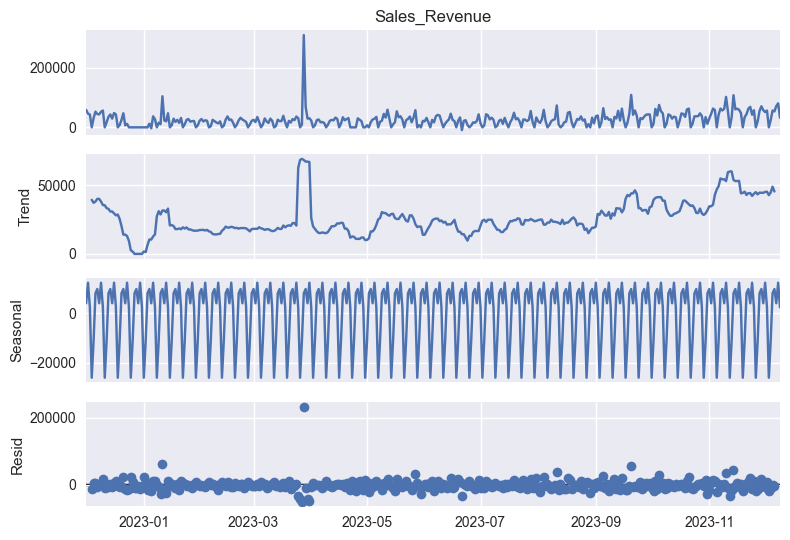

In [137]:
# As we saw we have 0 revenue days so we cannot use mulitplicative decomposition of time series so let's use the additive model
result_decompose_add = seasonal_decompose(daily_profit_online_sales['Sales_Revenue'], model='additive').plot()

As we can see the trend is positive and I can see no obvious seasonality from the chart, we can see the outliers in residual. I am thinking to use a decomposition method which is robust to outliers and irregularities such as holidays and regular zeros (on sundays). there are other methods that are more robust to outliers like STL (Seasonal-Trend decomposition using LOESS) or STL (Seasonal Trend decomposition using moving averages). Let's apply STL decomposition and I would do that with daily, monthly, seasonal and 3 days structure to see the differences

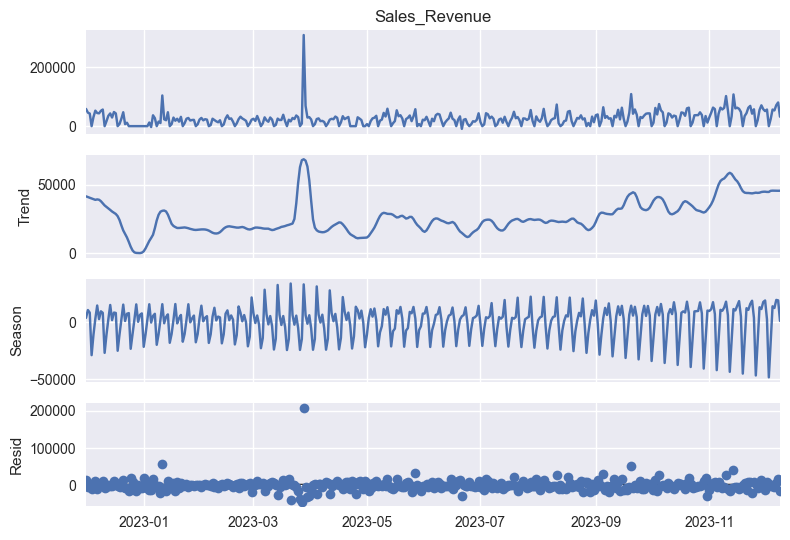

In [138]:
# Bi-weekly trend and seasonal trend
y=daily_profit_online_sales['Sales_Revenue']
stl = STL(y, seasonal=15)
res = stl.fit()
fig = res.plot()


We can see some kind of oscillation and shows a seasonality and the noise or residual does have the outliers and most of them are close to 0 (although the y access has a really high value so may be 10000s close to zero so we cannot detect 0s like this) seeThe oscillation is clear and there is a seasonallity. As times go by the amount of revenue increases and the amplitute of oscillations increases from september to the end of the year. The overall trend is increasing and residuals are the same as additive model. At least the variations and differences in resid is not obvious.Let's test with other seasonalities 

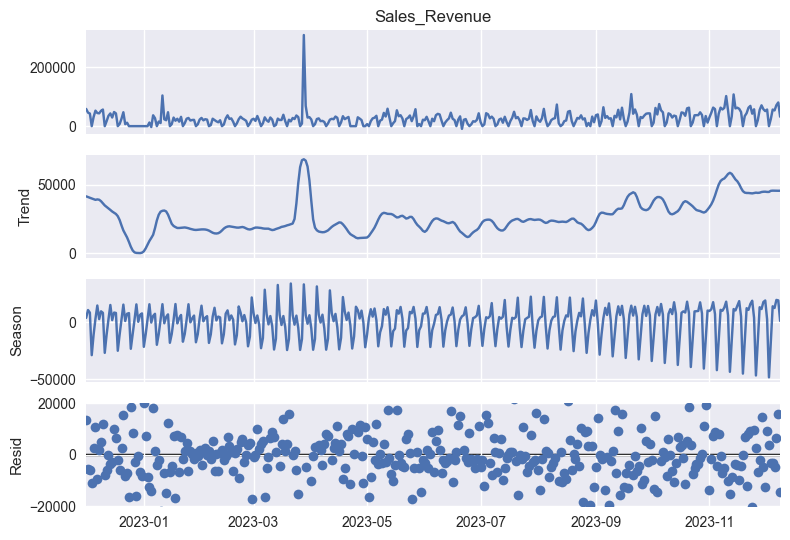

In [139]:
# Let's make the resid y numbers and zeros  more readable by scaling it 
fig = res.plot()

# Adjust y-axis limits and scale for residual plot
axes = fig.get_axes()
axes[3].set_ylim(-20000, 20000)  # Set y-axis limits for better visibility of residuals
axes[3].tick_params(axis='y', labelsize=10)  # Optional: Adjust y-axis scale for better readability

# Show plot
plt.show()
# I would apply this to all of the decomposition plots

We can see the residual is not 0. just from 2023 feb till march we can see 0 resid so we have lots of noise.

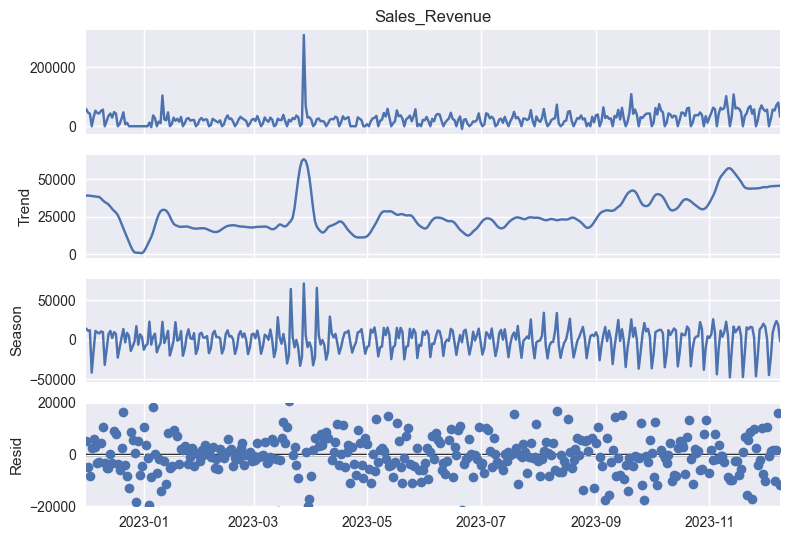

In [140]:
# Weekly trend and seasonal trend
y=daily_profit_online_sales['Sales_Revenue']
stl = STL(y, seasonal=7)
res = stl.fit()
fig = res.plot()

# Adjust y-axis limits and scale for residual plot
axes = fig.get_axes()
axes[3].set_ylim(-20000, 20000)  # Set y-axis limits for better visibility of residuals
axes[3].tick_params(axis='y', labelsize=10)  # Optional: Adjust y-axis scale for better readability

# Show plot
plt.show()
# I would apply this to all of the decomposition plots

In weekly  we can see the data is more intense in resid plot toward 0.

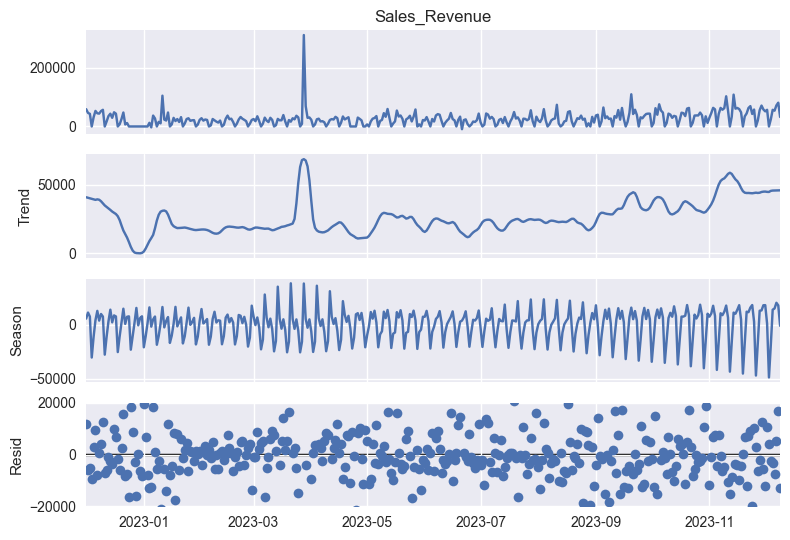

In [141]:
# bi-weeely trend and seasonal trend
y=daily_profit_online_sales['Sales_Revenue']
stl = STL(y, seasonal=13)
res = stl.fit()
fig = res.plot()

# Adjust y-axis limits and scale for residual plot
axes = fig.get_axes()
axes[3].set_ylim(-20000, 20000)  # Set y-axis limits for better visibility of residuals
axes[3].tick_params(axis='y', labelsize=10)  # Optional: Adjust y-axis scale for better readability

# Show plot
plt.show()
# I would apply this to all of the decomposition plots

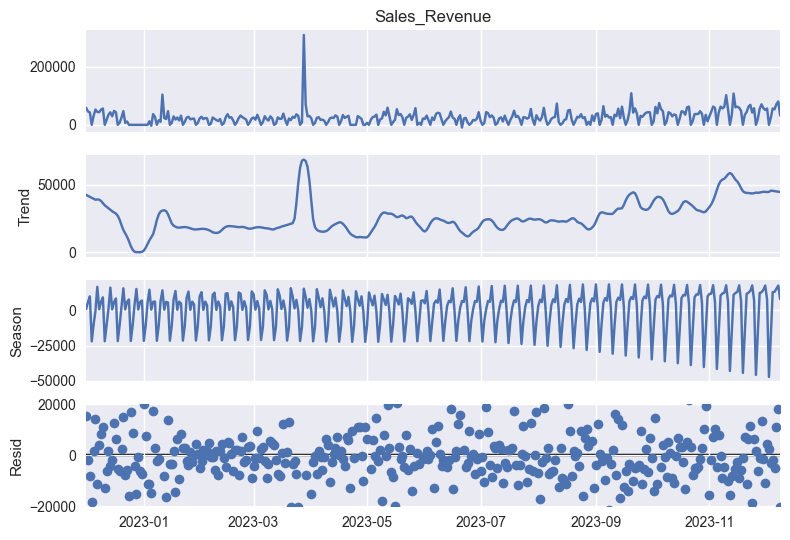

In [142]:
# monthly trend and seasonal trend based on season
y=daily_profit_online_sales['Sales_Revenue']
stl = STL(y, seasonal=31)
res = stl.fit()
fig = res.plot()

# Adjust y-axis limits and scale for residual plot
axes = fig.get_axes()
axes[3].set_ylim(-20000, 20000)  # Set y-axis limits for better visibility of residuals
axes[3].tick_params(axis='y', labelsize=10)  # Optional: Adjust y-axis scale for better readability

# Show plot
plt.show()
# I would apply this to all of the decomposition plots

The seasonality exists as we can deduct from the oscillations in the plot.

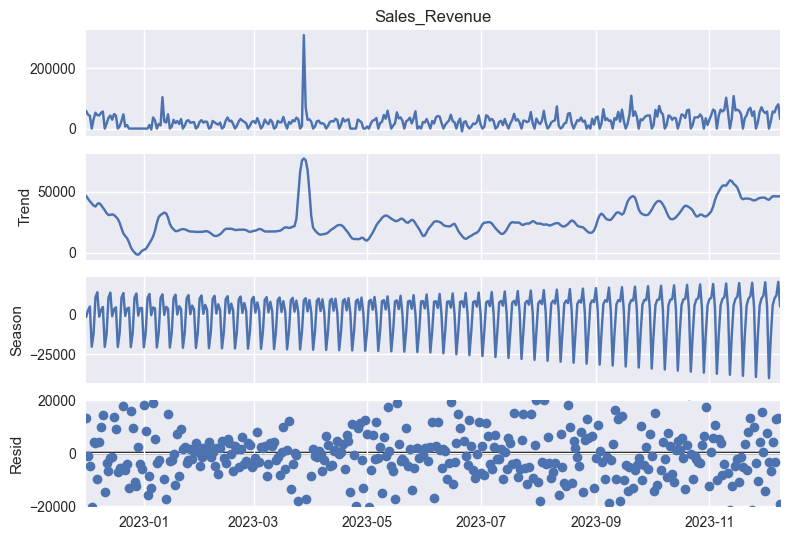

In [143]:
# bi monthly trend and seasonal trend based on season
y=daily_profit_online_sales['Sales_Revenue']
stl = STL(y, seasonal=61)
res = stl.fit()
fig = res.plot()

# Adjust y-axis limits and scale for residual plot
axes = fig.get_axes()
axes[3].set_ylim(-20000, 20000)  # Set y-axis limits for better visibility of residuals
axes[3].tick_params(axis='y', labelsize=10)  # Optional: Adjust y-axis scale for better readability

# Show plot
plt.show()
# I would apply this to all of the decomposition plots

In bimonthly plot we can see the seasonality which cause increas in revenue as we move forward in time. Let's do the monthly seasonality as well.

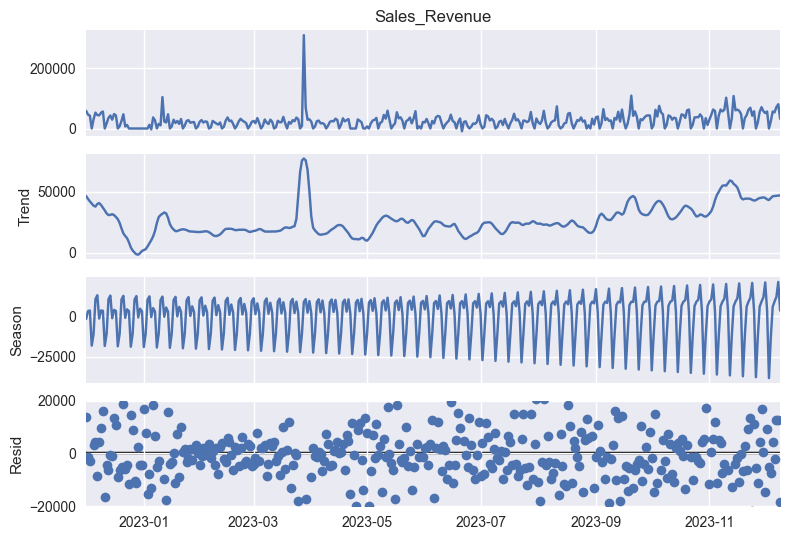

In [144]:
# let's see the seasonal seasonality
# literal seasonal  trend and seasonal trend based on season
y=daily_profit_online_sales['Sales_Revenue']
stl = STL(y, seasonal=89)
res = stl.fit()
fig = res.plot()

# Adjust y-axis limits and scale for residual plot
axes = fig.get_axes()
axes[3].set_ylim(-20000, 20000)  # Set y-axis limits for better visibility of residuals
axes[3].tick_params(axis='y', labelsize=10)  # Optional: Adjust y-axis scale for better readability

# Show plot
plt.show()
# I would apply this to all of the decomposition plots

In [145]:
daily_profit_online_sales

,Sales_Revenue,week_day,month,is_holiday_uk,Season
index,,,,,
2022-12-01,58709.27,Thursday,December,0,Winter
2022-12-02,46021.82,Friday,December,0,Winter
2022-12-03,42847.67,Saturday,December,0,Winter
2022-12-04,0.00,Sunday,December,0,Winter
2022-12-05,30982.01,Monday,December,0,Winter
...,...,...,...,...,...
2023-12-05,56480.62,Tuesday,December,0,Winter
2023-12-06,53535.94,Wednesday,December,0,Winter
2023-12-07,71500.46,Thursday,December,0,Winter


(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='trend'>)

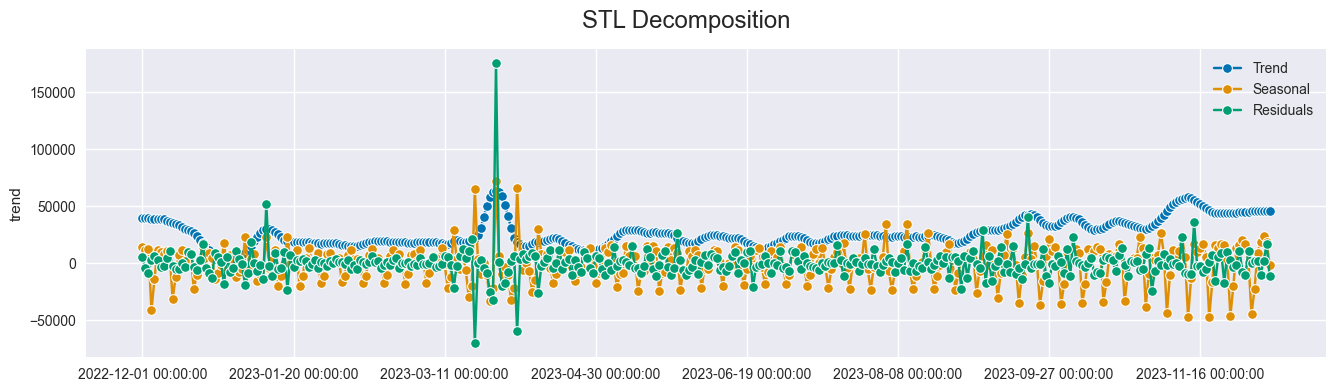

In [146]:
y=daily_profit_online_sales['Sales_Revenue']
# perform STL decomposition
stl_result = STL(y, seasonal=7).fit()
# Get the trend, seasonal, and residual components
y_trend = stl_result.trend
y_seasonal = stl_result.seasonal
y_residuals = stl_result.resid

# Visualize the components
plot_series(y_trend, y_seasonal, y_residuals,
            labels=["Trend", "Seasonal", "Residuals"],
            title="STL Decomposition")

We can see there is obviously seasonality either weekly or monthly. The best and most obvious one was weekly and yearly. We can detect the exact cycle of seasonality in autocorrelation and partial autocorrelation sections.

We saw that we have days with 0 entries but to ensure we have entry for every day , I am going to set the frequency of the dataframe to 'D'. (I can do this by subtracting the start index and the last index and compare it to number of rows in the datafraeme).

In [147]:
daily_profit_online_sales = daily_profit_online_sales.asfreq('D') # set the frequency of the time series to daily
daily_profit_online_sales.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 374 entries, 2022-12-01 to 2023-12-09
Freq: D
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Sales_Revenue  374 non-null    float64 
 1   week_day       374 non-null    category
 2   month          374 non-null    category
 3   is_holiday_uk  374 non-null    int32   
 4   Season         374 non-null    category
dtypes: category(3), float64(1), int32(1)
memory usage: 17.4 KB


Now let's jump into analysis of Stationarity and Heteroscedasticity.
Here is our to-do list:
- [ ] Do Dickey Fuller test , then confirm it by more exact capture of seasonality by Mann-Kendall and KPSS

- [ ] We obsereved seasonality exists especially for weekly and bi-weekly frequencies. with Autocorrelation and Partial Autocorrelation we can detect the obvious seasonality pattern.

- [ ] The heteroscedasticity test confirms that our series is heteroscedastic. It shows  that the spread of the residuals changes as the value of the independent variable  changes which violates the assumption of linear regression which assumes that the variance of the errors is constant(homoscedasticity). If heteroscedasticity is present, it can lead to biased and inefficient estimates of the regression coefficients, affecting the reliability of the model's predictions.In our case it means that the spread or dispersion of sales revenue values fluctuates as we move along the time axis.



In [148]:
# We expect to have non-stationary dataset as seasonality and trend are both present
result = adfuller(daily_profit_online_sales['Sales_Revenue'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

if result[1] <= 0.05:
    print("Reject the null hypothesis. Time series is stationary.")
else:
    print("Fail to reject the null hypothesis. Time series is non-stationary.")

ADF Statistic: -2.8448792646091854
p-value: 0.05214352269852066
Critical Values: {'1%': -3.448645946352023, '5%': -2.869602139060357, '10%': -2.5710650077160495}
Fail to reject the null hypothesis. Time series is non-stationary.


we see that ADF STatistics value is less negative  than two first critical values, it suggests that that the time series most probably is stationary.
Since this p-value is greater than 0.05, we fail to reject the null hypothesis. This means that we do not have enough evidence to conclude that the time series is stationary. So, the  the time series of sales revenue is non-stationary.
Let's see how Mann-kendall test interpret the status of stationarity of Sales Revenue time series:

In [149]:
# Mann-Kendall test function
def check_trend(time_series, alpha=0.05):
    """
    Perform the Mann-Kendall test for stationarity on a time series.
    
    H0: No monotonic trend --> Stationary
    Ha : Monotonic trend is present --> Non-Stationary (i.e.  trend exists)
    
    Assumptions
    
    - No correlation
    - No seasonality



    Parameters:
    - time_series: pandas Series or DataFrame column containing the time series data.
    - alpha: Significance level for the test.

    Returns:
    - result: pymannkendall test result object.
    """
    result = mk.original_test(time_series, alpha=alpha)
    return result

In [150]:
# Mann-Kendall test
check_trend(daily_profit_online_sales['Sales_Revenue'].dropna(), alpha=0.05)

Mann_Kendall_Test(trend='increasing', h=True, p=1.509292690826669e-10, z=6.404432954222747, Tau=0.22111510946079627, s=15423.0, var_s=5798558.333333333, slope=61.6033962264151, intercept=12651.521603773585)

The Mann-Kendall test is a  test used to detect trends in time series data. It specifically detects trends

Trend: The trend='increasing' indicates that the test detected a statistically significant increasing trend in the data.

Significance: The h=True indicates that the null hypothesis of no trend was rejected at the specified significance level(0.05). In this case, the trend was considered statistically significant.

p-value: The p=1.509292690826669e-10 is the p-value associated with the test. It represents the probability of observing the data if there were no trend. A very low p-value (close to zero) indicates strong evidence against the null hypothesis(which is the reverse of ADF and assumes there is no trend and the datset is stationary)

z-value: The z=6.404432954222747 is the test statistic, which measures the strength of the trend. Larger absolute values indicate stronger evidence of a trend.

Tau: The Tau=0.22111510946079627 is the Kendall's Tau statistic, which measures the strength and direction of the trend. A positive Tau indicates an increasing trend.

s and var_s: These are related to the test statistic and its variance and are used in the calculation of the p-value.

Slope and Intercept: The slope=61.6033962264151 and intercept=12651.521603773585 represent the estimated slope and intercept of the trend line fitted to the data.

In summary, the Mann-Kendall test results indicate that there is a statistically significant increasing trend in the data, with a strong positive correlation between the variable and time. It confirms what we observed from the decomposition of the timeseries of sales revenue. Out of curiousity I want to do KPSS test as well.


In [151]:
# KPSS test
result = kpss(daily_profit_online_sales['Sales_Revenue'])
print('KPSS Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[3])

# Interpret the result
if result[1] < 0.05:
    print('Reject the null hypothesis. The data is non-stationary.')
else:
    print('Fail to reject the null hypothesis. The data is stationary.')

KPSS Statistic: 1.6578881512946346
p-value: 0.01
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
Reject the null hypothesis. The data is non-stationary.


C:\Users\donna\AppData\Local\Temp\ipykernel_17944\2756184366.py:2: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.




We can see that the p-value is close to 0 so we can reject the null hypothesis with high confidence and conclude that the data is not stationary.
The critical values at different significance levels are provided for comparison. These values represent the thresholds beyond which we would reject the null hypothesis of stationarity.Based on the result, we can conclude that the data is non-stationary. This means that there are trends or patterns in the data that need to be accounted for in time series analysis and modeling.
Now let's jump into analysis of Stationarity and Heteroscedasticity.
Here is our to-do list:
- [x] Do Dickey Fuller test , then confirm it by more exact capture of seasonality by Mann-Kendall and KPSS. As the result is that our timeseries is not stationary another step added:
-[ ] Make the series stationary by transformation and then check for the stationarity and if it is stationary move to the next stap.

- [ ] We obsereved seasonality exists especially for weekly and bi-weekly frequencies. with Autocorrelation and Partial Autocorrelation we can detect the obvious seasonality pattern.

- [ ] The heteroscedasticity test confirms that our series is heteroscedastic. It shows  that the spread of the residuals changes as the value of the independent variable  changes which violates the assumption of linear regression which assumes that the variance of the errors is constant(homoscedasticity). If heteroscedasticity is present, it can lead to biased and inefficient estimates of the regression coefficients, affecting the reliability of the model's predictions.In our case it means that the spread or dispersion of sales revenue values fluctuates as we move along the time axis.

Now let's first make our data stationary:
 First method is diffrenciating between consecutive observations (first difference) and test if it is stationary or not.But I think as i have extreme outliers that I kept I should use more robust transformar such as boxcoox such method is the use of a power transformation, specifically the Box-Cox transformation, which can handle outliers to some extent. 
 **I know that the code give error but it was part of my experiment so I would like to include in my assignment**


In [152]:

# Add a small constant to avoid taking the log of zero
data_no_zeros = daily_profit_online_sales['Sales_Revenue'] + np.finfo(float).eps

# Apply the Box-Cox transformation
transformed_data, lambda_value = boxcox(data_no_zeros)
daily_profit_online_sales['transformed_Revenue']=transformed_data
# Check for stationarity in the transformed data
# ADF method
result = adfuller(transformed_data)
print('ADF Statistic:', result[0])
print('p-value:', result[1])
# Mann-Kendall method
check_trend(transformed_data, alpha=0.05)

# KPSS Method
result = kpss(transformed_data)
print('KPSS Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[3])

# Interpret the result
if result[1] < 0.05:
    print('Reject the null hypothesis. The data is non-stationary.')
else:
    print('Fail to reject the null hypothesis. The data is stationary.')

# Plot the transformed data
plt.plot(transformed_data)
plt.show()

# See the transformed_data
daily_profit_online_sales

ValueError: Data must be positive.

Since box cox doesn't accept negative values I use another transformaer called which is an extension of the Box-Cox transformation and supports both positive and negative values.

ADF Statistic: -2.8691698937019776
p-value: 0.04905237481894891
Critical Values: {'1%': -3.448645946352023, '5%': -2.869602139060357, '10%': -2.5710650077160495}
Reject the null hypothesis. Time series is stationary.


Mann_Kendall_Test(trend='increasing', h=True, p=1.509292690826669e-10, z=6.404432954222747, Tau=0.22111510946079627, s=15423.0, var_s=5798558.333333333, slope=13.943305447590072, intercept=3654.611052806468)

KPSS Statistic: 1.585741055745362
p-value: 0.01
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
Reject the null hypothesis. The data is non-stationary.


C:\Users\donna\AppData\Local\Temp\ipykernel_17944\3554479791.py:19: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.




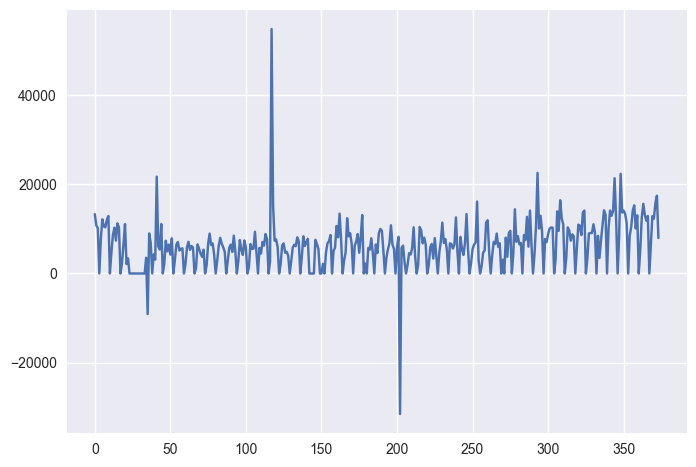

,Sales_Revenue,week_day,month,is_holiday_uk,Season,transformed_Revenue
2022-12-01,58709.27,Thursday,December,0,Winter,13315.810923
2022-12-02,46021.82,Friday,December,0,Winter,10826.016729
2022-12-03,42847.67,Saturday,December,0,Winter,10187.841831
2022-12-04,0.00,Sunday,December,0,Winter,0.000000
2022-12-05,30982.01,Monday,December,0,Winter,7733.227360
...,...,...,...,...,...,...
2023-12-05,56480.62,Tuesday,December,0,Winter,12884.832992
2023-12-06,53535.94,Wednesday,December,0,Winter,12311.447142
2023-12-07,71500.46,Thursday,December,0,Winter,15744.999400
2023-12-08,80704.29,Friday,December,0,Winter,17452.193229


In [156]:
transformed_data, lambda_value = yeojohnson(daily_profit_online_sales['Sales_Revenue'])
daily_profit_online_sales['transformed_Revenue']=transformed_data
# Check for stationarity in the transformed data
# ADF method
# We expect to have non-stationary dataset as seasonality and trend are both present
result = adfuller(transformed_data)
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

if result[1] <= 0.05:
    print("Reject the null hypothesis. Time series is stationary.")
else:
    print("Fail to reject the null hypothesis. Time series is non-stationary.")
# Mann-Kendall method
display(check_trend(transformed_data, alpha=0.05))

# KPSS Method
result = kpss(transformed_data)
print('KPSS Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[3])

# Interpret the result
if result[1] < 0.05:
    print('Reject the null hypothesis. The data is non-stationary.')
else:
    print('Fail to reject the null hypothesis. The data is stationary.')

# Plot the transformed data
plt.plot(transformed_data)
plt.show()

# See the transformed_data
daily_profit_online_sales


I got conflicting results for stationarity: ADF test shows that it is stationary(the p-value is so close to 0.05) while KPSS and Mann-Kendall test show that series is not stationary(as the p-value of both are new to 0 the null hypothesis which is reverse of the ADF test is rejected so the data is non-stationary). Let's try the robust scaler:

In [155]:
scaler = RobustScaler()
scaled_data = scaler.fit_transform(daily_profit_online_sales[['Sales_Revenue']])
daily_profit_online_sales['transformed_Revenue']=scaled_data
display(daily_profit_online_sales)

,Sales_Revenue,week_day,month,is_holiday_uk,Season,transformed_Revenue
2022-12-01,58709.27,Thursday,December,0,Winter,1.292476
2022-12-02,46021.82,Friday,December,0,Winter,0.818110
2022-12-03,42847.67,Saturday,December,0,Winter,0.699433
2022-12-04,0.00,Sunday,December,0,Winter,-0.902581
2022-12-05,30982.01,Monday,December,0,Winter,0.255792
...,...,...,...,...,...,...
2023-12-05,56480.62,Tuesday,December,0,Winter,1.209150
2023-12-06,53535.94,Wednesday,December,0,Winter,1.099052
2023-12-07,71500.46,Thursday,December,0,Winter,1.770720
2023-12-08,80704.29,Friday,December,0,Winter,2.114839


ADF Statistic: -2.8691698937019776
p-value: 0.04905237481894891
Critical Values: {'1%': -3.448645946352023, '5%': -2.869602139060357, '10%': -2.5710650077160495}
Reject the null hypothesis. Time series is stationary.


Mann_Kendall_Test(trend='increasing', h=True, p=1.509292690826669e-10, z=6.404432954222747, Tau=0.22111510946079627, s=15423.0, var_s=5798558.333333333, slope=13.943305447590072, intercept=3654.611052806468)

KPSS Statistic: 1.585741055745362
p-value: 0.01
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
Reject the null hypothesis. The data is non-stationary.


C:\Users\donna\AppData\Local\Temp\ipykernel_17944\3500163905.py:17: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.




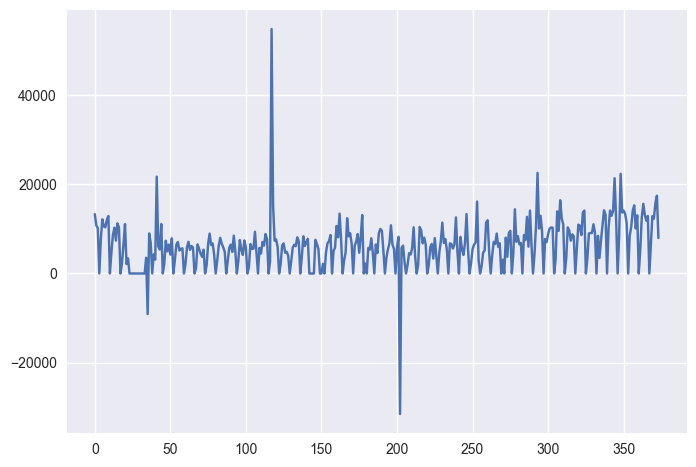

,Sales_Revenue,week_day,month,is_holiday_uk,Season,transformed_Revenue
2022-12-01,58709.27,Thursday,December,0,Winter,13315.810923
2022-12-02,46021.82,Friday,December,0,Winter,10826.016729
2022-12-03,42847.67,Saturday,December,0,Winter,10187.841831
2022-12-04,0.00,Sunday,December,0,Winter,0.000000
2022-12-05,30982.01,Monday,December,0,Winter,7733.227360
...,...,...,...,...,...,...
2023-12-05,56480.62,Tuesday,December,0,Winter,12884.832992
2023-12-06,53535.94,Wednesday,December,0,Winter,12311.447142
2023-12-07,71500.46,Thursday,December,0,Winter,15744.999400
2023-12-08,80704.29,Friday,December,0,Winter,17452.193229


In [157]:
# Check for stationarity in the transformed data
# ADF method
# We expect to have non-stationary dataset as seasonality and trend are both present
result = adfuller(transformed_data)
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

if result[1] <= 0.05:
    print("Reject the null hypothesis. Time series is stationary.")
else:
    print("Fail to reject the null hypothesis. Time series is non-stationary.")
# Mann-Kendall method
display(check_trend(transformed_data, alpha=0.05))

# KPSS Method
result = kpss(transformed_data)
print('KPSS Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[3])

# Interpret the result
if result[1] < 0.05:
    print('Reject the null hypothesis. The data is non-stationary.')
else:
    print('Fail to reject the null hypothesis. The data is stationary.')

# Plot the transformed data
plt.plot(transformed_data)
plt.show()

# See the transformed_data
daily_profit_online_sales

Still the stationarity test results conflict So I think I would use another transformation method: apply a square root transformation with a shift as we have negative values. I would like to see the autocorrelation and partial autocorrelation but I think that Prophet will be the best model for this timeseries.

In [158]:
shifted_data = daily_profit_online_sales[['Sales_Revenue']] - daily_profit_online_sales[['Sales_Revenue']].min() + 1
sqrt_transformed_data = np.sqrt(shifted_data)
daily_profit_online_sales[['sqrt_transformed_Revenue']]=sqrt_transformed_data
daily_profit_online_sales

,Sales_Revenue,week_day,month,is_holiday_uk,Season,transformed_Revenue,sqrt_transformed_Revenue
2022-12-01,58709.27,Thursday,December,0,Winter,13315.810923,260.647194
2022-12-02,46021.82,Friday,December,0,Winter,10826.016729,235.052143
2022-12-03,42847.67,Saturday,December,0,Winter,10187.841831,228.200263
2022-12-04,0.00,Sunday,December,0,Winter,0.000000,96.060866
2022-12-05,30982.01,Monday,December,0,Winter,7733.227360,200.523565
...,...,...,...,...,...,...,...
2023-12-05,56480.62,Tuesday,December,0,Winter,12884.832992,256.336322
2023-12-06,53535.94,Wednesday,December,0,Winter,12311.447142,250.526705
2023-12-07,71500.46,Thursday,December,0,Winter,15744.999400,284.126996
2023-12-08,80704.29,Friday,December,0,Winter,17452.193229,299.886612


ADF Statistic: -2.631063984042424
p-value: 0.08674541332576735
Critical Values: {'1%': -3.448645946352023, '5%': -2.869602139060357, '10%': -2.5710650077160495}
Fail to reject the null hypothesis. Time series is non-stationary.


Mann_Kendall_Test(trend='increasing', h=True, p=1.509292690826669e-10, z=6.404432954222747, Tau=0.22111510946079627, s=15423.0, var_s=5798558.333333333, slope=0.16876710417352728, intercept=151.1947044045765)

KPSS Statistic: 1.9929378074012583
p-value: 0.01
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
Reject the null hypothesis. The data is non-stationary.


C:\Users\donna\AppData\Local\Temp\ipykernel_17944\173447256.py:17: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.




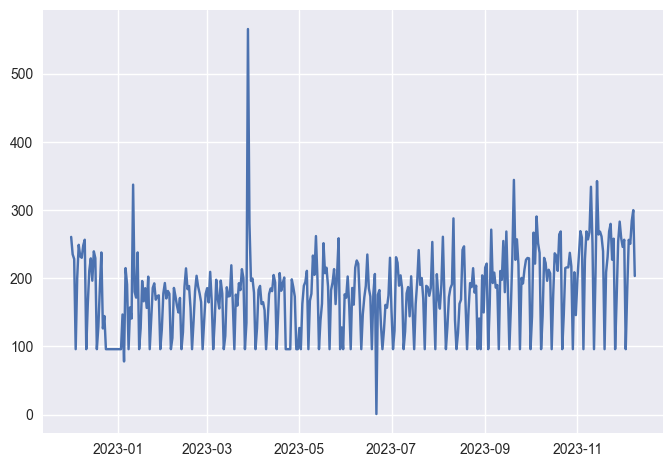

,Sales_Revenue,week_day,month,is_holiday_uk,Season,transformed_Revenue,sqrt_transformed_Revenue
2022-12-01,58709.27,Thursday,December,0,Winter,13315.810923,260.647194
2022-12-02,46021.82,Friday,December,0,Winter,10826.016729,235.052143
2022-12-03,42847.67,Saturday,December,0,Winter,10187.841831,228.200263
2022-12-04,0.00,Sunday,December,0,Winter,0.000000,96.060866
2022-12-05,30982.01,Monday,December,0,Winter,7733.227360,200.523565
...,...,...,...,...,...,...,...
2023-12-05,56480.62,Tuesday,December,0,Winter,12884.832992,256.336322
2023-12-06,53535.94,Wednesday,December,0,Winter,12311.447142,250.526705
2023-12-07,71500.46,Thursday,December,0,Winter,15744.999400,284.126996
2023-12-08,80704.29,Friday,December,0,Winter,17452.193229,299.886612


In [159]:
# Check for stationarity in the transformed data
# ADF method
# We expect to have non-stationary dataset as seasonality and trend are both present
result = adfuller(sqrt_transformed_data)
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

if result[1] <= 0.05:
    print("Reject the null hypothesis. Time series is stationary.")
else:
    print("Fail to reject the null hypothesis. Time series is non-stationary.")
# Mann-Kendall method
display(check_trend(sqrt_transformed_data, alpha=0.05))

# KPSS Method
result = kpss(sqrt_transformed_data)
print('KPSS Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[3])

# Interpret the result
if result[1] < 0.05:
    print('Reject the null hypothesis. The data is non-stationary.')
else:
    print('Fail to reject the null hypothesis. The data is stationary.')

# Plot the transformed data
plt.plot(sqrt_transformed_data)
plt.show()

# See the transformed_data
daily_profit_online_sales

In [160]:
differenced_data = daily_profit_online_sales[['Sales_Revenue']].diff().dropna()
daily_profit_online_sales[['differenced_data']]=differenced_data
daily_profit_online_sales

,Sales_Revenue,week_day,month,is_holiday_uk,Season,transformed_Revenue,sqrt_transformed_Revenue,differenced_data
2022-12-01,58709.27,Thursday,December,0,Winter,13315.810923,260.647194,NaN
2022-12-02,46021.82,Friday,December,0,Winter,10826.016729,235.052143,-12687.45
2022-12-03,42847.67,Saturday,December,0,Winter,10187.841831,228.200263,-3174.15
2022-12-04,0.00,Sunday,December,0,Winter,0.000000,96.060866,-42847.67
2022-12-05,30982.01,Monday,December,0,Winter,7733.227360,200.523565,30982.01
...,...,...,...,...,...,...,...,...
2023-12-05,56480.62,Tuesday,December,0,Winter,12884.832992,256.336322,32052.44
2023-12-06,53535.94,Wednesday,December,0,Winter,12311.447142,250.526705,-2944.68
2023-12-07,71500.46,Thursday,December,0,Winter,15744.999400,284.126996,17964.52
2023-12-08,80704.29,Friday,December,0,Winter,17452.193229,299.886612,9203.83


ADF Statistic: -9.177171190196967
p-value: 2.3034113197129886e-15
Critical Values: {'1%': -3.448645946352023, '5%': -2.869602139060357, '10%': -2.5710650077160495}
Reject the null hypothesis. Time series is stationary.


Mann_Kendall_Test(trend='no trend', h=False, p=0.42583456142888276, z=0.7963397946323163, Tau=0.027631237568105163, s=1917.0, var_s=5788875.0, slope=8.416683569979709, intercept=147.656855983774)

KPSS Statistic: 0.2609408519745194
p-value: 0.1
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
Fail to reject the null hypothesis. The data is stationary.


C:\Users\donna\AppData\Local\Temp\ipykernel_17944\539958545.py:17: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




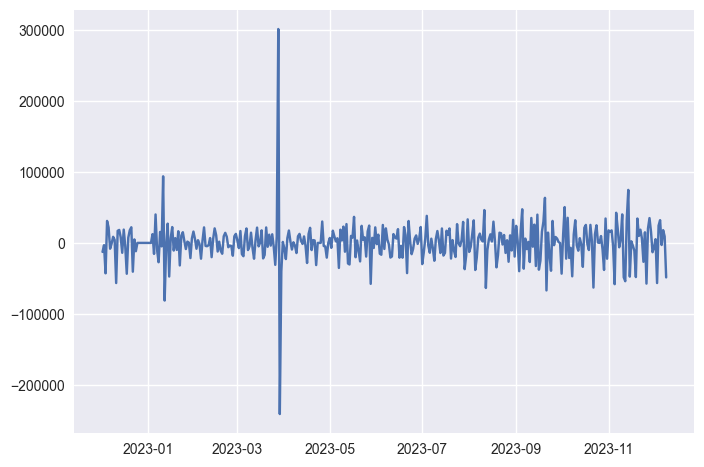

,Sales_Revenue,week_day,month,is_holiday_uk,Season,transformed_Revenue,sqrt_transformed_Revenue,differenced_data
2022-12-01,58709.27,Thursday,December,0,Winter,13315.810923,260.647194,NaN
2022-12-02,46021.82,Friday,December,0,Winter,10826.016729,235.052143,-12687.45
2022-12-03,42847.67,Saturday,December,0,Winter,10187.841831,228.200263,-3174.15
2022-12-04,0.00,Sunday,December,0,Winter,0.000000,96.060866,-42847.67
2022-12-05,30982.01,Monday,December,0,Winter,7733.227360,200.523565,30982.01
...,...,...,...,...,...,...,...,...
2023-12-05,56480.62,Tuesday,December,0,Winter,12884.832992,256.336322,32052.44
2023-12-06,53535.94,Wednesday,December,0,Winter,12311.447142,250.526705,-2944.68
2023-12-07,71500.46,Thursday,December,0,Winter,15744.999400,284.126996,17964.52
2023-12-08,80704.29,Friday,December,0,Winter,17452.193229,299.886612,9203.83


In [161]:
# Check for stationarity in the transformed data
# ADF method
# We expect to have non-stationary dataset as seasonality and trend are both present
result = adfuller(differenced_data)
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

if result[1] <= 0.05:
    print("Reject the null hypothesis. Time series is stationary.")
else:
    print("Fail to reject the null hypothesis. Time series is non-stationary.")
# Mann-Kendall method
display(check_trend(differenced_data, alpha=0.05))

# KPSS Method
result = kpss(differenced_data)
print('KPSS Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[3])

# Interpret the result
if result[1] < 0.05:
    print('Reject the null hypothesis. The data is non-stationary.')
else:
    print('Fail to reject the null hypothesis. The data is stationary.')

# Plot the transformed data
plt.plot(differenced_data)
plt.show()

# See the transformed_data
daily_profit_online_sales

 Now the data is stationary. All the three tests confirm that the differentiated online sales revenue is stationary now.Let's see the autocorrelation and partial autocorrelation.

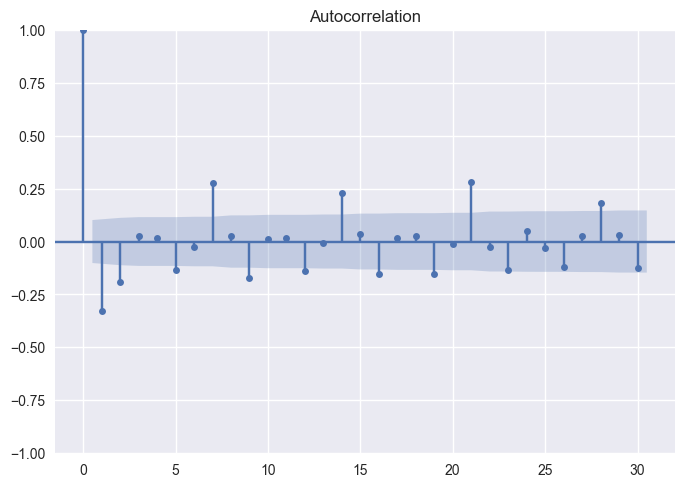

In [162]:
# Seasonality

acf = plot_acf(daily_profit_online_sales['differenced_data'].dropna(), lags=30)


It can be observed that every 7 days we have repeatetive significantly high autocorrelation of above the confidence area. We can also see that every 3-4 days have -15%ish correlation. it suggests that there is a weekly seasonality in revenue with differentiator as transformer with some additional variation occurring every 3 to 4 days below confidence area which shows high negative correlation till 26th lags (days before).We can see that the autocorrelation value decreases as the lags increases Let's see the partial autocorrelation to see what lag is the most important:


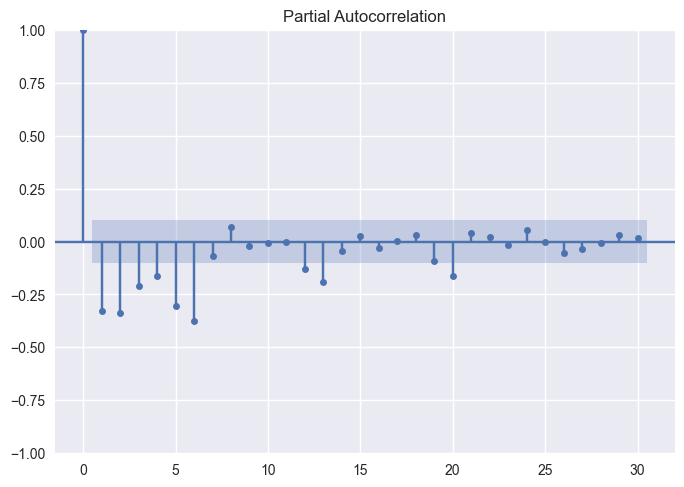

In [163]:
pacf = plot_pacf(daily_profit_online_sales['differenced_data'].dropna(), lags=30)

The weekly seasonality is also obvious in partial correlation plot: every 6 and 7 days lags, the revenue  have strong negative correlation with the differenciated revenue we have today.
The partial autocorrelation plot indicates the strength and direction of the relationship between each lagged day and the current day, while controlling for the effects of the intermediate lags. Here's the observations:

6th Lagged Day: The strong negative correlation (around -40%) at the 6th lag indicates that there is a significant inverse relationship between the observation 6 days ago and the current observation. This suggests a weekly pattern or seasonality in online revenue.

2nd Lagged Day: The moderate negative correlation (around -30%) at the 2nd lag suggests that there is also a shorter-term, negative relationship between the observation 2 days ago and the current observation.

1st Lagged Day: The correlation at the 1st lag (around -30%, less than lag 2) indicates that there is a similar, but slightly weaker, negative relationship between the observation 1 day ago and the current observation.

5th Lagged Day: The correlation at the 5th lag (around 28%) suggests a moderate positive relationship between the observation 5 days ago and the current observation, which is opposite to the negative relationships at lags 1, 2, and 6.

lags 3&13 & 20 with approximately  the same high correlation below the confidence area which shows a strong negative relationship
lags 4&12 with the same high correlation below the confidence area which shows a strong negative relationship with the current value of the revenue and the main effect on autocorrelation plot comes from all the above partial correlations.

Here is our to-do list:
- [x] Do Dickey Fuller test , then confirm it by more exact capture of seasonality by Mann-Kendall and KPSS

- [x] We obsereved seasonality exists especially for weekly and bi-weekly frequencies. with Autocorrelation and Partial Autocorrelation we can detect the obvious seasonality pattern.

**Let's see the heteroscedasticity**

- [ ] The heteroscedasticity test confirms that our series is heteroscedastic. It shows  that the spread of the residuals changes as the value of the independent variable  changes which violates the assumption of linear regression which assumes that the variance of the errors is constant(homoscedasticity). If heteroscedasticity is present, it can lead to biased and inefficient estimates of the regression coefficients, affecting the reliability of the model's predictions.In our case it means that the spread or dispersion of sales revenue values fluctuates as we move along the time axis.

In [164]:
# Heterosedasticity

def _check_convert_y(y):
    assert not np.any(np.isnan(y)), "`y` should not have any nan values"
    if isinstance(y, (pd.Series, pd.DataFrame)):
        y = y.values.squeeze()
    assert y.ndim==1
    return y



def check_heteroscedastisticity(y, confidence=0.05):
    y = _check_convert_y(y)
    res = namedtuple("White_Test", ["heteroscedastic", "lm_statistic", "lm_p_value"])
    #Fitting a linear trend regression
    x = np.arange(len(y))
    x = sm.add_constant(x)
    model = sm.OLS(y,x)
    results = model.fit()
    lm_stat, lm_p_value, f_stat, f_p_value = het_white(results.resid, x)
    if lm_p_value<confidence and f_p_value < confidence:
        hetero = True
    else:
        hetero = False
    return res(hetero, lm_stat, lm_p_value)

In [168]:
### Check for heterocecdasticity

display(check_heteroscedastisticity(daily_profit_online_sales['differenced_data'].dropna(), confidence = 0.05))
display(check_heteroscedastisticity(daily_profit_online_sales['Sales_Revenue'].dropna(), confidence = 0.05))

White_Test(heteroscedastic=False, lm_statistic=0.21184998227003415, lm_p_value=0.8994921154282071)

White_Test(heteroscedastic=False, lm_statistic=0.06018783806643424, lm_p_value=0.970354394522119)


The result of the White test indicates that there is no evidence of heteroscedasticity in the residuals of our transformed time serises. The test statistic (lm_statistic) is 0.2118, and the p-value (lm_p_value) is 0.8995.

Since the p-value is greater than the typical significance level of 0.05, we fail to reject the null hypothesis of homoscedasticity (constant variance) in favor of the alternative hypothesis of heteroscedasticity. Therefore, the data does not exhibit heteroscedasticity based on the White test.
We can see that for the sales revenue the pvalue is even higher so there is no heteroscedasticity

Here is our to-do list:
- [x] Do Dickey Fuller test , then confirm it by more exact capture of seasonality by Mann-Kendall and KPSS. As the result is that our timeseries is not stationary another step added:
-[x] Make the series stationary by transformation and then check for the stationarity and if it is stationary move to the next stap.

- [x] We obsereved seasonality exists especially for weekly and bi-weekly frequencies. with Autocorrelation and Partial Autocorrelation we can detect the obvious seasonality pattern.

- [x] The heteroscedasticity test confirms that our series is heteroscedastic. It shows  that the spread of the residuals changes as the value of the independent variable  changes which violates the assumption of linear regression which assumes that the variance of the errors is constant(homoscedasticity). If heteroscedasticity is present, it can lead to biased and inefficient estimates of the regression coefficients, affecting the reliability of the model's predictions.In our case it means that the spread or dispersion of sales revenue values fluctuates as we move along the time axis.

**All done**
Now let's move on to modelling

I am going to move to a new notebook as this is so heavy and my VS is so slow, but I am going to list my next steps here:
1. Save the variables and csv s to import to the new notebook
2. summarize what we have done so far
3. First work on a basic model  Naive model
5. Then move to more complex one KNN
6. Then move TO GXBoost
7. Then SARIMA MODEL
8. and at last the Prophet model which I think is the best model for my case
9. Evaluation error matrix for both the regular and the one with outliers  and adding chart for each model combined in one chart

What we have done so far:
- Descriptive analysis adne extracting date features
- analyzed each feature, the distribution, outliers and null values
- removed null values
- after carefully analyzing the outliers, I decided to keep all the outliers and consider the negative values and outliers when creating models.
- I cleaned the data on unit and price and removed all the weired and out of range that I couldn't substitute.
- I substitute the unit price for where we have the stock code and the unit price but by mistake the unit price is 0.
- Also adding a revenue column which multiplies the unit price by quantity and analyze the target versus time and other variables versus time adn target
- I then moved to the analysis of behaviour of the dataframe by decompising it and adding week_day,monthly and seasonal columns to see hte behaviour. Using additive model I detected the positive trend and noise
- Did different tests Dickey Fuller, KPSS and mann-kendall and all of them confirmed it is not stationary
- I used different transformers to see which one makes the time series stationary. The differenciation transformer worked great and comes out of all three test successfully as stationary.
- I did autocorrelation and partial autocorrelation and I saw very strong correlations and seasonality:
    The partial autocorrelation plot indicates the strength and direction of the relationship between each lagged day and the current day, while controlling for the effects of the intermediate lags. Here's the observations:

    6th Lagged Day: The strong negative correlation (around -40%) at the 6th lag indicates that there is a significant inverse relationship between the observation 6 days ago and the current observation. This suggests a weekly pattern or seasonality in online revenue.

    2nd Lagged Day: The moderate negative correlation (around -30%) at the 2nd lag suggests that there is also a shorter-term, negative relationship between the observation 2 days ago and the current observation.

    1st Lagged Day: The correlation at the 1st lag (around -30%, less than lag 2) indicates that there is a similar, but slightly weaker, negative relationship between the observation 1 day ago and the current observation.

    5th Lagged Day: The correlation at the 5th lag (around 28%) suggests a moderate positive relationship between the observation 5 days ago and the current observation, which is opposite to the negative relationships at lags 1, 2, and 6.

    lags 3&13 & 20 with approximately  the same high correlation below the confidence area which shows a strong negative relationship
    lags 4&12 with the same high correlation below the confidence area which shows a strong negative relationship with the current value of the revenue and the main effect on autocorrelation plot comes from all the above partial correlations.

Seasonality:
It can be observed that every 7 days we have repeatetive significantly high autocorrelation of above the confidence area. We can also see that every 3-4 days have -15%ish correlation. it suggests that there is a weekly seasonality in revenue with differentiator as transformer with some additional variation occurring every 3 to 4 days below confidence area which shows high negative correlation till 26th lags (days before).

Now I am going to save the data and work on the first set of models:
- Naive, KNN and GXBOOST
- SARIMA for the next section (If I have time)
- Prophet for the last model(If I have time)
- Then compare the error matrix with regular matrix and some extra error matrixes that are robust to outliersand negative values. Choose the bet performance one.
- Then if I have time research on other models and how to make the model better


In [ ]:


# Save the dataframes into CSV files
online_sales.reset_index(inplace=True)
online_sales.rename(columns={'index': 'invoiceDate'}, inplace=True)
daily_profit_online_sales.reset_index(inplace=True)
daily_profit_online_sales.rename(columns={'index': 'invoiceDate'}, inplace=True)
daily_profit_online_sales.to_csv('daily_profit_online_sales.csv', index=False)
online_sales.to_csv('online_sales.csv', index=False)
display(daily_profit_online_sales)
display(online_sales)

,invoiceDate,Sales_Revenue,week_day,month,is_holiday_uk,Season,transformed_Revenue,sqrt_transformed_Revenue,differenced_data
0,2022-12-01,58709.27,Thursday,December,0,Winter,1.292476,260.647194,NaN
1,2022-12-02,46021.82,Friday,December,0,Winter,0.818110,235.052143,-12687.45
2,2022-12-03,42847.67,Saturday,December,0,Winter,0.699433,228.200263,-3174.15
3,2022-12-04,0.00,Sunday,December,0,Winter,-0.902581,96.060866,-42847.67
4,2022-12-05,30982.01,Monday,December,0,Winter,0.255792,200.523565,30982.01
...,...,...,...,...,...,...,...,...,...
369,2023-12-05,56480.62,Tuesday,December,0,Winter,1.209150,256.336322,32052.44
370,2023-12-06,53535.94,Wednesday,December,0,Winter,1.099052,250.526705,-2944.68
371,2023-12-07,71500.46,Thursday,December,0,Winter,1.770720,284.126996,17964.52
372,2023-12-08,80704.29,Friday,December,0,Winter,2.114839,299.886612,9203.83


,invoiceDate,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,Abs_Quantity,Sales_Revenue
0,2022-12-01,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850,United Kingdom,6,15.30
1,2022-12-01,536365,71053,WHITE METAL LANTERN,6,3.39,17850,United Kingdom,6,20.34
2,2022-12-01,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,17850,United Kingdom,8,22.00
3,2022-12-01,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,17850,United Kingdom,6,20.34
4,2022-12-01,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,17850,United Kingdom,6,20.34
...,...,...,...,...,...,...,...,...,...,...
536451,2023-12-09,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,0.85,12680,France,12,10.20
536452,2023-12-09,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2.10,12680,France,6,12.60
536453,2023-12-09,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,4.15,12680,France,4,16.60
536454,2023-12-09,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,4.15,12680,France,4,16.60
